In [9]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy
from scipy import stats
from scipy.special import expit
import plotly.express as px
import pandas as pd
from tqdm import tqdm
np.random.seed(42)

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message="use_inf_as_na option is deprecated")
warnings.filterwarnings("ignore", category=UserWarning, message="KMeans is known to have a memory leak on Windows with MKL")
warnings.filterwarnings("ignore", category=RuntimeWarning)
#############################################################################
#############################################################################
#############################################################################

# Sampling from von Mises Fisher distribution

def _random_VMF_cos(d, kappa, n):
    """
    Generate n iid samples of cos(theta) from the marginal density:
    p(t) ∝ (1 - t^2)^{(d-2)/2} * exp(kappa * t)
    using the algorithm of Ulrich (1984) / Wood (1994).
    """
    if kappa == 0:
        # Uniform case
        return 2 * np.random.rand(n) - 1
    
    b = (d - 1) / (2 * kappa + np.sqrt(4 * kappa**2 + (d - 1)**2))
    x0 = (1 - b) / (1 + b)
    c = kappa * x0 + (d - 1) * np.log(1 - x0**2)

    samples = []
    while len(samples) < n:
        m = int((n - len(samples)) * 1.5)
        z = np.random.beta((d - 1) / 2, (d - 1) / 2, size=m)
        t = (1 - (1 + b) * z) / (1 - (1 - b) * z)
        u = np.random.uniform(size=m)
        accept = kappa * t + (d - 1) * np.log(1 - x0 * t) - c >= np.log(u)
        samples.extend(t[accept])
    return np.array(samples[:n])


def random_VMF(mu, kappa, size=None):
    """
    Von Mises-Fisher sampler on S^{d-1} in R^d
    Parameters:
        mu: mean direction (array of shape (d,))
        kappa: concentration parameter (float >= 0)
        size: number of samples (int or tuple)
    Returns:
        Samples on the unit sphere in R^d
    """
    mu = np.asarray(mu)
    mu = mu / np.linalg.norm(mu)
    d = mu.shape[0]

    if size is None:
        n = 1
        shape = ()
    else:
        n = np.prod(size)
        shape = size if isinstance(size, tuple) else (size,)

    # Sample cos(theta)
    cos_theta = _random_VMF_cos(d, kappa, n)
    sin_theta = np.sqrt(1 - cos_theta**2)

    # Sample uniformly in the orthogonal complement of mu
    v = np.random.randn(n, d)
    proj = v - (v @ mu)[:, None] * mu
    proj_norm = np.linalg.norm(proj, axis=1, keepdims=True)
    proj_unit = proj / proj_norm

    # Combine to get samples on sphere
    samples = cos_theta[:, None] * mu + sin_theta[:, None] * proj_unit
    return samples.reshape((*shape, d))


#############################################################################
#############################################################################
#############################################################################

#Trace convergence

def gelman_rubin_rhat(chains):
    m, n = chains.shape
    chain_means = np.mean(chains, axis=1)
    chain_vars = np.var(chains, axis=1, ddof=1)
    
    B = n * np.var(chain_means, ddof=1)
    W = np.mean(chain_vars)
    var_hat = ( (n - 1)/n ) * W + (1/n) * B
    R_hat = np.sqrt(var_hat / W)
    return R_hat

def effective_sample_size(chains, max_lag=1000):
    m, n = chains.shape
    mean_chain = np.mean(chains)
    var_chain = np.var(chains, ddof=1)
    autocorr_sum = 0.0
    for lag in range(1, max_lag):
        acov_lag = 0.0
        for chain in chains:
            acov = np.cov(chain[:-lag], chain[lag:])[0, 1]
            acov_lag += acov
        acov_lag /= m
        rho = acov_lag / var_chain
        if rho <= 0: 
            break
        autocorr_sum += 2 * rho
    ess =   1 / (1 + autocorr_sum)
    return ess


def extract_parameter_chains(results_per_chain, Model):
    n_chains = len(results_per_chain)
    n_samples = results_per_chain[0]['samples']['alpha'].shape[0]

    chains = {}
    alpha_chains = np.zeros((n_chains, n_samples))
    for i, result in enumerate(results_per_chain):
        alpha_chains[i, :] = result['samples']['alpha']
    chains['alpha'] = alpha_chains

    Z_samples = results_per_chain[0]['samples']['Z']
    n_nodes = Z_samples.shape[1]
    d = Z_samples.shape[2]

    Z_chains = {}
    for node in range(n_nodes):
        for dim in range(d):
            key = f"Z_{node}_{dim}"
            Z_chains[key] = np.zeros((n_chains, n_samples))
            for i, result in enumerate(results_per_chain):
                Z_chains[key][i, :] = result['samples']['Z'][:, node, dim]
    chains.update(Z_chains)

    if Model == 'Spherical':
        beta_chains = np.zeros((n_chains, n_samples))
        for i, result in enumerate(results_per_chain):
            beta_chains[i, :] = result['samples']['beta']
        chains['beta'] = beta_chains

    return chains

def compute_diagnostics_dataframe(results_per_chain, Model, max_lag=1000):

    chains_dict = extract_parameter_chains(results_per_chain, Model)

    diagnostics = []
    
    for param, chain_array in chains_dict.items():
        R_hat = gelman_rubin_rhat(chain_array)
        ESS = effective_sample_size(chain_array, max_lag=max_lag)
        diagnostics.append({'parameter': param, 'R_hat': round(R_hat,4), 'ESS/n': round(ESS,4)})
    
    df = pd.DataFrame(diagnostics)
    return df

def merge_results(results_per_chain, Model):
    n_chains = len(results_per_chain)
    n_samples = results_per_chain[0]['samples']['alpha'].shape[0]
    
    alpha_all = np.concatenate([res['samples']['alpha'] for res in results_per_chain], axis=0)
    
    Z_shape = results_per_chain[0]['samples']['Z'].shape  # (n_samples, n_nodes, d)
    n_nodes = Z_shape[1]
    d = Z_shape[2]
    Z_all = np.concatenate([res['samples']['Z'] for res in results_per_chain], axis=0)

    log_likelihood_all = np.concatenate([res['log_likelihood'] for res in results_per_chain])
    log_prior_all = np.concatenate([res['log_prior'] for res in results_per_chain])
    log_posterior_all = np.concatenate([res['log_posterior'] for res in results_per_chain])
  
    acceptance_alpha_all = np.concatenate([res['acceptance_rate_trace']['alpha'] for res in results_per_chain], axis=0)
    acceptance_Z_all = np.concatenate([res['acceptance_rate_trace']['Z'] for res in results_per_chain], axis=0)

    sigma_q_alpha_all = np.mean([res['final_proposal_std']['alpha'] for res in results_per_chain])
    sigma_q_Z_all = np.mean([res['final_proposal_std']['Z'] for res in results_per_chain])

    if Model == "Euclidean":
        results = {
            'samples': {'Z': Z_all, "alpha": alpha_all},
            'acceptance_rate_trace': {'Z': acceptance_Z_all, "alpha": acceptance_alpha_all},
            'log_likelihood': log_likelihood_all,
            'log_prior': log_prior_all,
            'log_posterior': log_posterior_all,
            'final_proposal_std': {'Z': sigma_q_Z_all, "alpha": sigma_q_alpha_all},
        }
    
    if Model == "Spherical":
        beta_all = np.concatenate([res['samples']['beta'] for res in results_per_chain], axis=0)
        acceptance_beta_all = np.concatenate([res['acceptance_rate_trace']['beta'] for res in results_per_chain], axis=0)
        sigma_q_beta_all = np.mean([res['final_proposal_std']['beta'] for res in results_per_chain])

        results = {
            'samples': {'Z': Z_all, "alpha": alpha_all, "beta": beta_all},
            'acceptance_rate_trace': {'Z': acceptance_Z_all, "alpha": acceptance_alpha_all, "beta": acceptance_beta_all},
            'log_likelihood': log_likelihood_all,
            'log_prior': log_prior_all,
            'log_posterior': log_posterior_all,
            'final_proposal_std': {'Z': sigma_q_Z_all, "alpha": sigma_q_alpha_all, "beta": sigma_q_beta_all},
        }
    
    return results


#############################################################################
#############################################################################
#############################################################################

import numpy as np
from scipy.special import expit  # sigmoid

def compute_model_criteria(Y, samples_Z, samples_alpha, samples_beta=None):
    """
    Compute WAIC, DIC, and BIC for Latent Space Models 
    (both Euclidean and Spherical versions).

    Parameters:
        Y : (n, n) numpy array
            Observed adjacency matrix.
        samples_Z : (L, n, d) numpy array
            MCMC samples of latent positions.
        samples_alpha : (L,) numpy array
            MCMC samples of the alpha parameter.
        samples_beta : (L,) numpy array, optional
            MCMC samples of the beta parameter (for Spherical model).

    Returns:
        dic, waic, bic : floats
            The Deviance Information Criterion (DIC), 
            the Watanabe-Akaike Information Criterion (WAIC), 
            and the Bayesian Information Criterion (BIC).
    """
    
    L, n, d = samples_Z.shape
    log_lik = np.zeros((L, n, n))
    
    for l in range(L):
        for i in range(n):
            for j in range(n):
                if i != j:
                    if samples_beta is None:  
                        dist = np.linalg.norm(samples_Z[l, i] - samples_Z[l, j])
                        eta = samples_alpha[l] - dist
                    else: 
                        dot = np.dot(samples_Z[l, i], samples_Z[l, j])
                        eta = samples_alpha[l] + samples_beta[l] * dot

                    p_ij = expit(eta)
                    log_lik[l, i, j] = np.log(p_ij + 1e-10) if Y[i, j] == 1 else np.log(1 - p_ij + 1e-10)
                else:
                    log_lik[l, i, j] = 0.0

    ## WAIC
    lppd = np.sum(np.log(np.mean(np.exp(log_lik), axis=0) + 1e-10))
    p_waic = np.sum(np.var(log_lik, axis=0))
    waic = -2 * (lppd - p_waic)

    ## DIC
    deviance_samples = -2 * np.sum(log_lik, axis=(1, 2))
    mean_deviance = np.mean(deviance_samples)

    # Evaluate deviance at posterior mean
    Z_mean = np.mean(samples_Z, axis=0)
    alpha_mean = np.mean(samples_alpha)
    beta_mean = np.mean(samples_beta) if samples_beta is not None else None

    log_lik_mean = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                if samples_beta is None:
                    dist = np.linalg.norm(Z_mean[i] - Z_mean[j])
                    eta = alpha_mean - dist
                else:
                    dot = np.dot(Z_mean[i], Z_mean[j])
                    eta = alpha_mean + beta_mean * dot

                p_ij = expit(eta)
                log_lik_mean[i, j] = np.log(p_ij + 1e-10) if Y[i, j] == 1 else np.log(1 - p_ij + 1e-10)
            else:
                log_lik_mean[i, j] = 0.0

    deviance_mean = -2 * np.sum(log_lik_mean)
    p_dic = mean_deviance - deviance_mean
    dic = mean_deviance + p_dic


    log_lik_sum_mean = np.sum(log_lik_mean)
    k = n * d + 1  
    if samples_beta is not None:
        k += 1 
    n_obs = np.sum(Y != np.eye(n))
    bic = -2 * log_lik_sum_mean + k * np.log(n_obs)
    
    return dic, waic, bic
#############################################################################
#############################################################################
#############################################################################

# Estimation procedure

def Estimation_LSMN(Y, Theta, Model):
    print("="*80)   
    print(f"Metropolis-Hastings for {Model} latent space models on networks")
    print("="*80)

    min_ar, max_ar = 0.3, 0.5
    
    n = Y.shape[0]
    Z0 = Theta['Z0']
    alpha0 = Theta['alpha0']
    if Model == "Spherical": beta0 = Theta['beta0']
    if Model == "Euclidean": sigma_prior_Z = Theta['sigma_prior_Z']
    sigma_prior_alpha = Theta['sigma_prior_alpha']
    if Model == "Spherical": 
        sigma_prior_beta = Theta['sigma_prior_beta']
        rho = Theta['rho'] 
        mu_alpha_beta = Theta['mu_alpha_beta'] 

    d = Z0.shape[1]

    n_samples = Theta['n_samples']
    sigma_q_Z = Theta['sigma_q_Z']
    sigma_q_alpha = Theta['sigma_q_alpha']
    if Model == "Spherical": sigma_q_beta = Theta['sigma_q_beta']
    burn_in = Theta['burn_in']
    thin = Theta['thin']
    n_iterations = n_samples * thin + burn_in
    n_chains = Theta['n_chains']    

    mask = np.arange(burn_in, n_iterations, thin)

    print(f"Number of chains: {n_chains}")
    print(f"MH samples of size {n_samples} with burn-in {burn_in} and thinning {thin}")
    print(f"Number of draws per chain: {n_iterations}")
    

    

    print(f"Initial sigma_q_Z: {sigma_q_Z:.4f}")
    print(f"Initial sigma_q_alpha: {sigma_q_alpha:.4f}")
    if Model == "Spherical": print(f"Initial sigma_q_beta: {sigma_q_beta:.4f}")

    
    if Model == "Euclidean":
        def compute_Z_star(Z, Z0):
            """ Computes Z* = Z0 Z^T (Z Z0^T Z0 Z^T)^(-1/2) Z using SVD """
            A = Z @ Z0.T @ Z0 @ Z.T 
            U, S, _ = np.linalg.svd(A)
            S_inv_sqrt = np.diag(1.0 / (np.sqrt(S) + 1e-10))
            A_inv_sqrt = U @ S_inv_sqrt @ U.T
            Z_star =  Z0 @ Z.T @ A_inv_sqrt @ Z
            # Compute Z*
            return Z_star - np.mean(Z_star, axis=0)
    if Model == "Spherical":
        def compute_Z_star(Z, Z0):
            """
            Orthogonal Procrustes alignment following Schönemann (1966):
            Finds rotation R = V U^T such that Z @ R best approximates Z0.
            """
            Z = np.asarray(Z)
            Z0 = np.asarray(Z0)
            M = Z0.T @ Z
            U, S, Vt = np.linalg.svd(M)

            R = Vt.T @ U.T
            Z_star = Z @ R

            return Z_star

    print("Log-likelihood: Bernoulli")
    def log_likelihood(params):
        total = 0.0
        if Model == "Euclidean":
            Z, alpha = params
            for i in range(n):
                for j in range(i+1,n):
                    dist = np.linalg.norm(Z[i] - Z[j])
                    eta = alpha - dist
                    total += eta * Y[i,j] + (-np.logaddexp(0, eta))
        if Model == "Spherical":
            Z, alpha, beta = params
            for i in range(n):
                for j in range(i+1,n):
                    dist = Z[i].T @ Z[j]
                    eta = alpha + beta * dist
                    total += eta * Y[i,j] + (-np.logaddexp(0, eta))
        return total
    
    def grad_loglikelihood(params):
        grad_alpha = 0.0
        grad_beta = 0.0
        if Model == "Euclidean":
            Z, alpha = params
            grad_Z = np.zeros_like(Z)
            for i in range(n):
                for j in range(i+1,n):
                    dist = np.linalg.norm(Z[i] - Z[j])
                    eta = alpha - dist
                    grad_Z[i,:] += (-1) * ((Z[i] - Z[j])/(dist + 1e-10)) * (Y[i,j] - expit(eta))
                    grad_alpha +=  (Y[i,j] - expit(eta))
            return grad_Z, grad_alpha
        if Model == "Spherical":
            Z, alpha, beta = params
            grad_Z = np.zeros_like(Z)
            for i in range(n):
                for j in range(i+1,n):
                    dist = Z[i].T @ Z[j] 
                    eta = alpha + beta*dist
                    grad_Z[i,:] +=  (Y[i,j] - expit(eta)) *  (beta * Z[j])
                    grad_alpha += (Y[i,j] - expit(eta)) * (1) 
                    grad_beta += (Y[i,j] - expit(eta)) * (dist) 
            return grad_Z, grad_alpha, grad_beta

    print("-"*60)

    def SearchingMLE(params, max_iter=250, tol=1e-3, r_init=0.1, rho=0.5, c=1e-4):

        if Model == "Euclidean":
            Z0, alpha0 = params
        if Model == "Spherical":
            Z0, alpha0, beta0 = params
        
        def update_Z(Z, grad_Z):
            for i in range(len(Z)):
                proj_orth = grad_Z[i]-np.dot(Z[i], grad_Z[i]) * Z[i]
                Z[i] = Z[i] + proj_orth 
                Z[i] = Z[i] / np.linalg.norm(Z[i])
            return Z

        Zi = Z0.copy()
        alphai = np.float64(alpha0).copy()
        historyZ = [Zi]
        historyalpha = [alphai]
        if Model == "Spherical": 
            betai = np.float64(beta0).copy()
            historybeta = [betai]

        for i in range(max_iter):
            r = r_init
            if Model == "Euclidean":
                grad_Z, grad_alpha = grad_loglikelihood((Zi,alphai))
                while log_likelihood((Zi + r * grad_Z, alphai+r*grad_alpha)) < log_likelihood((Zi,alphai))+ c * r * (np.sum(grad_Z * grad_Z) + grad_alpha**2):
                    r *= rho
                    if r < 1e-9:
                        r = 0.0
                        break
            if Model == "Spherical":
                grad_Z, grad_alpha, grad_beta = grad_loglikelihood((Zi,alphai,betai))
                while  log_likelihood((update_Z(Zi, r*grad_Z) ,alphai+r*grad_alpha,betai+r*grad_beta)) < log_likelihood((Zi,alphai,betai))+ c * r * (np.sum(grad_Z * grad_Z) + grad_alpha**2 + grad_beta**2):
                    r *= rho
                    if r < 1e-9:
                        r = 0.0
                        break
            
            if Model == "Euclidean":
                Zi = Zi + r * grad_Z  
                alphai = alphai + r * grad_alpha
                historyZ.append(Zi)
                historyalpha.append(alphai)
                if np.linalg.norm(grad_Z) < tol and np.abs(grad_alpha) < tol:
                    break
            if Model == "Spherical":
                Zi = update_Z(Zi, r * grad_Z) 
                alphai = alphai + r * grad_alpha
                betai = betai + r * grad_beta
                historyZ.append(Zi)
                historyalpha.append(alphai)
                historybeta.append(betai)
                if np.linalg.norm(grad_Z) < tol and np.abs(grad_alpha) < tol and np.abs(grad_beta) < tol:
                    break


        if Model == "Euclidean":  
            return  Zi, alphai
        if Model == "Spherical":
            return  Zi, alphai, betai
            
    def MultiStartMLE(n_starts=10, max_iter=150, tol=1e-3):
        print("Searching for MLE using gradient ascent")
        best_ll = -np.inf
        best_params = None

        for s in range(n_starts):
            # Random initialization
            Z0 = np.random.randn(n, d)
            Z0 = Z0 / np.linalg.norm(Z0, axis=1, keepdims=True) if Model == "Spherical" else sigma_prior_Z * Z0
            alpha0 = sigma_prior_alpha * np.random.normal()
            if Model == "Spherical":
                alpha_beta_0 = np.random.multivariate_normal(mu_alpha_beta , np.array([[sigma_prior_alpha**2,rho*sigma_prior_alpha*sigma_prior_beta],[rho*sigma_prior_alpha*sigma_prior_beta,sigma_prior_beta**2]]), size=1)
                alpha0 = np.float64(alpha_beta_0[0,0])
                beta0 = np.float64(alpha_beta_0[0,1])
            # Run optimization
            if Model == "Euclidean":
                params = SearchingMLE((Z0,alpha0), max_iter=max_iter, tol=tol)
                ll = log_likelihood(params)
            if Model == "Spherical":
                params = SearchingMLE((Z0,alpha0,beta0),max_iter=max_iter, tol=tol)
                ll = log_likelihood(params)
            if ll > best_ll:
                best_ll = ll
                best_params = params

        print(f"Best log-likelihood after {n_starts} starts: {best_ll:.4f}")
        return best_params



    if Model == "Euclidean":
        Z_ML, alpha_ML = MultiStartMLE(n_starts=20)
    if Model == "Spherical":
        Z_ML, alpha_ML, beta_ML = MultiStartMLE(n_starts=20) 
        
    print("-"*60)    

    print("Log-prior:")
    if Model == "Euclidean": print("sigma_prior_Z: ", sigma_prior_Z)
    print("sigma_prior_alpha: ", sigma_prior_alpha)
    if Model == "Spherical": print("sigma_prior_beta: ", sigma_prior_beta)
    
    def log_prior(params):
        total = 0.0
        if Model == "Euclidean":
            Z, alpha = params
            total += - 0.5 * n * d * np.log(2 * np.pi)- n * np.log(sigma_prior_Z) - 0.5 * np.sum(Z**2) / sigma_prior_Z**2
            total += - 0.5 * np.log(2 * np.pi)- np.log(sigma_prior_alpha) - 0.5 * alpha**2 / sigma_prior_alpha**2
        if Model == "Spherical":
            Z, alpha, beta = params
            total += - 0.5 * n * d * np.log(2 * np.pi) + n * np.log(scipy.special.gamma(d/2))
            Sigma_prior_inv = (1/(sigma_prior_alpha**2 * sigma_prior_beta**2 * (1 - rho**2))) * np.array([[sigma_prior_beta**2,-rho*sigma_prior_alpha*sigma_prior_beta],[-rho*sigma_prior_alpha*sigma_prior_beta,sigma_prior_alpha**2]])
            total += - np.log(2 * np.pi)- np.log(sigma_prior_alpha*sigma_prior_beta*np.sqrt(1-rho**2)) - 0.5 * ((np.array([alpha, beta]) - mu_alpha_beta).T @ Sigma_prior_inv @ (np.array([alpha, beta]) - mu_alpha_beta))
        return total
    
    results_per_chain = []

    for chain in range(n_chains):

        sigma_q_Z = Theta['sigma_q_Z']
        sigma_q_alpha = Theta['sigma_q_alpha']
        if Model == "Spherical": sigma_q_beta = Theta['sigma_q_beta']

        Z_current = Z_ML.copy()
        alpha_current = np.float64(alpha_ML).copy()
        if Model == "Spherical": beta_current = np.float64(beta_ML).copy()

        Z_chain = np.zeros((n_iterations, n, d))
        alpha_chain = np.zeros(n_iterations)
        if Model == "Spherical": beta_chain = np.zeros(n_iterations)

        acceptance_rate_trace_Z = np.zeros(n_iterations)
        acceptance_rate_trace_alpha = np.zeros(n_iterations)
        if Model == "Spherical": acceptance_rate_trace_beta = np.zeros(n_iterations)

        log_likelihood_chain = np.zeros(n_iterations)
        log_prior_chain = np.zeros(n_iterations)
        log_posterior_chain = np.zeros(n_iterations)

        accept_count_Z = 0
        total_updates_Z = 0

        accept_count_alpha = 0
        total_updates_alpha = 0

        if Model == "Spherical":
            accept_count_beta = 0
            total_updates_beta = 0

        if Model == "Euclidean":
            params_current = (Z_current,alpha_current)
            current_ll = log_likelihood(params_current)
            current_lp = log_prior(params_current)
        if Model == "Spherical":
            params_current = (Z_current,alpha_current,beta_current)
            current_ll = log_likelihood(params_current)
            current_lp = log_prior(params_current)
        current_post = current_ll + current_lp


        

        

        print("*"*32 + f"\nChain {chain}\n" + "*"*32)

        for i in tqdm(range(n_iterations), desc="Sampling progress", unit=" draws"):

            # Z update
            if Model == "Euclidean":
                Z_proposed = Z_current + np.random.normal(0, sigma_q_Z, size=(n, d))
                proposed_params = (Z_proposed, alpha_current)

            elif Model == "Spherical":
                Z_proposed = np.array([random_VMF(Z_current[l], sigma_q_Z, size=1)[0] for l in range(n)])
                proposed_params = (Z_proposed, alpha_current, beta_current)

            proposed_ll = log_likelihood(proposed_params)
            proposed_lp = log_prior(proposed_params)
            proposed_post = proposed_ll + proposed_lp

            log_r = proposed_post - current_post

            if np.log(np.random.rand()) < log_r:
                Z_current = Z_proposed
                current_ll = proposed_ll
                current_lp = proposed_lp
                current_post = proposed_post
                accept_count_Z += 1

            total_updates_Z += 1

            Z_chain[i] = compute_Z_star(Z_current, Z_ML)
            acceptance_rate_trace_Z[i] = accept_count_Z / total_updates_Z if total_updates_Z > 0 else 0

            # alpha update
            alpha_proposed =  np.random.normal(alpha_current, sigma_q_alpha)
            if Model == "Euclidean":
                    proposed_params = (Z_current, alpha_proposed)
                    proposed_ll = log_likelihood(proposed_params)
                    proposed_lp = log_prior(proposed_params)
            if Model == "Spherical":
                proposed_params = (Z_current, alpha_proposed, beta_current)
                proposed_ll = log_likelihood(proposed_params)
                proposed_lp = log_prior(proposed_params)
            proposed_post = proposed_ll + proposed_lp
            log_r = proposed_post - current_post
            if np.log(np.random.rand()) < log_r:
                alpha_current = alpha_proposed
                current_ll = proposed_ll
                current_lp = proposed_lp
                current_post = proposed_post
                accept_count_alpha += 1
            total_updates_alpha += 1
            alpha_chain[i] = alpha_current
            acceptance_rate_trace_alpha[i] = accept_count_alpha / total_updates_alpha if total_updates_alpha > 0 else 0


            if Model == "Spherical":
                # beta update
                beta_proposed =  np.random.normal(beta_current, sigma_q_beta)
                proposed_ll = log_likelihood((Z_current, alpha_current, beta_proposed))
                proposed_lp = log_prior((Z_current, alpha_current, beta_proposed))
                proposed_post = proposed_ll + proposed_lp
                log_r = proposed_post - current_post  
                if np.log(np.random.rand()) < log_r:
                    beta_current = beta_proposed
                    current_ll = proposed_ll
                    current_lp = proposed_lp
                    current_post = proposed_post
                    accept_count_beta += 1
                total_updates_beta += 1
                beta_chain[i] = beta_current
                acceptance_rate_trace_beta[i] = accept_count_beta / total_updates_beta if total_updates_beta > 0 else 0



            # Diagnostics update  
            log_likelihood_chain[i] = current_ll
            log_prior_chain[i] = current_lp
            log_posterior_chain[i] = current_post


            # Tunning proposals
            if 0 < i < burn_in:
                if Model == "Euclidean":
                    acc_rate_Z = acceptance_rate_trace_Z[i]
                    acc_rate_alpha = acceptance_rate_trace_alpha[i]
                    factor_Z = 0.995 if acc_rate_Z < min_ar else 1.005 if acc_rate_Z > max_ar else 1.0
                    sigma_q_Z = np.minimum(np.maximum(sigma_q_Z * factor_Z, 0.001), 3.0)
                    factor_alpha = 0.995 if acc_rate_alpha < min_ar else 1.005 if acc_rate_alpha > max_ar else 1.0
                    sigma_q_alpha = np.minimum(np.maximum(sigma_q_alpha * factor_alpha, 0.001), 3.0)
                if Model == "Spherical":
                    acc_rate_Z = acceptance_rate_trace_Z[i]
                    acc_rate_alpha = acceptance_rate_trace_alpha[i]
                    acc_rate_beta = acceptance_rate_trace_beta[i]
                    factor_Z = 1.0005 if acc_rate_Z < min_ar else 0.9995 if acc_rate_Z > max_ar else 0.0
                    sigma_q_Z = np.minimum(np.maximum(sigma_q_Z * factor_Z, 1.0), 300.0)
                    factor_alpha = 0.995 if acc_rate_alpha < min_ar else 1.005 if acc_rate_alpha > max_ar else 1.0
                    sigma_q_alpha = np.minimum(np.maximum(sigma_q_alpha * factor_alpha, 0.001), 3.0)
                    factor_beta = 0.995 if acc_rate_beta < min_ar else 1.005 if acc_rate_beta > max_ar else 1.0
                    sigma_q_beta = np.minimum(np.maximum(sigma_q_beta * factor_beta, 0.001), 3.0)
                
            if i == burn_in:
                print("-"*32 + "\nTuning complete\n" + "-"*32)
                print(f"Final sigma_q_Z: {sigma_q_Z:.4f}")
                print(f"Final sigma_q_alpha: {sigma_q_alpha:.4f}")
                if Model == "Spherical": print(f"Final sigma_q_beta: {sigma_q_beta:.4f}")
        if Model == "Euclidean":
            results =  {
                'samples': {'Z': Z_chain[mask], "alpha": alpha_chain[mask]},
                'acceptance_rate_trace': {'Z': acceptance_rate_trace_Z[mask], "alpha": acceptance_rate_trace_alpha[mask]},
                'log_likelihood': log_likelihood_chain[mask],
                'log_prior': log_prior_chain[mask],
                'log_posterior': log_posterior_chain[mask],
                'final_proposal_std': {'Z': sigma_q_Z, "alpha": sigma_q_alpha},
            }
        if Model == "Spherical":
            results = {
            'samples': {'Z': Z_chain[mask], 'alpha': alpha_chain[mask], 'beta': beta_chain[mask]},
            'acceptance_rate_trace': {'Z': acceptance_rate_trace_Z[mask], 'alpha': acceptance_rate_trace_alpha[mask], 'beta': acceptance_rate_trace_beta[mask]},
            'log_likelihood': log_likelihood_chain[mask],
            'log_prior': log_prior_chain[mask],
            'log_posterior': log_posterior_chain[mask],
            'final_proposal_std': {'Z': sigma_q_Z, 'alpha': sigma_q_alpha, 'beta': sigma_q_beta},
            }

        results_per_chain.append(results)
    
    # Report R-hat and ESS

    print("*"*32 + f"\nTrace convergence\n" + "*"*32)

    df_diagnostics_trace_convergence = compute_diagnostics_dataframe(results_per_chain, Model)
    print(f"Minimum R-hat: {df_diagnostics_trace_convergence['R_hat'].min():.4f}")
    print(f"Maximum R-hat: {df_diagnostics_trace_convergence['R_hat'].max():.4f}")
    print(f"Minimum ESS/n: {df_diagnostics_trace_convergence['ESS/n'].min():.4f}")
    print(f"Maximum ESS/n: {df_diagnostics_trace_convergence['ESS/n'].max():.4f}")
    
    results = merge_results(results_per_chain, Model)

    Z_chain = results["samples"]['Z']
    alpha_chain = results["samples"]['alpha']
    if Model == "Spherical": 
        beta_chain = results["samples"]['beta']

    acceptance_rate_trace_Z = results['acceptance_rate_trace']['Z']
    acceptance_rate_trace_alpha = results['acceptance_rate_trace']['alpha']
    if Model == "Spherical": 
        acceptance_rate_trace_beta = results['acceptance_rate_trace']['beta']

    log_likelihood_chain = results['log_likelihood']
    log_prior_chain = results['log_prior']
    log_posterior_chain = results['log_posterior']

    # Point estimators
    ## Conditional mean
    Z_CM = np.mean(Z_chain, axis=0)
    alpha_CM = np.mean(alpha_chain)
    if Model == "Euclidean":
        cm_log_posterior = log_likelihood((Z_CM,alpha_CM)) + log_prior((Z_CM,alpha_CM))
    if Model == "Spherical":
        for i in range(n):
            Z_CM[i] /= np.linalg.norm(Z_CM[i])
        beta_CM = np.mean(beta_chain)
        cm_log_posterior = log_likelihood((Z_CM,alpha_CM,beta_CM)) + log_prior((Z_CM,alpha_CM,beta_CM))
    ## Maximum a posteriori
    map_index = np.argmax(log_posterior_chain)
    Z_MAP = Z_chain[map_index]
    alpha_MAP = alpha_chain[map_index]
    if Model == "Spherical": beta_MAP = beta_chain[map_index]
    map_log_posterior = log_posterior_chain[map_index]
    
    print("*"*32 + "\nPoint information\n" + "*"*32)
    
    if Model == "Euclidean":
        pointresults = {
        "Initial": {"ll": log_likelihood((Z0,alpha0)), "lp": log_prior((Z0,alpha0))},
        "ML": {"ll": log_likelihood((Z_ML,alpha_ML)), "lp": log_prior((Z_ML,alpha_ML))},
        "CM": {"ll": log_likelihood((Z_CM,alpha_CM)), "lp": log_prior((Z_CM,alpha_CM))},
        "MAP": {"ll": log_likelihood_chain[map_index], "lp": log_prior_chain[map_index]}
        }
    if Model == "Spherical":
        pointresults = {
        "Initial": {"ll": log_likelihood((Z0,alpha0,beta0)), "lp": log_prior((Z0,alpha0,beta0))},
        "ML": {"ll": log_likelihood((Z_ML,alpha_ML,beta_ML)), "lp": log_prior((Z_ML,alpha_ML,beta_ML))},
        "CM": {"ll": log_likelihood((Z_CM,alpha_CM,beta_CM)), "lp": log_prior((Z_CM,alpha_CM,beta_CM))},
        "MAP": {"ll": log_likelihood_chain[map_index], "lp": log_prior_chain[map_index]}
        }

    print("-"*64)
    print("{:<10} {:>16} {:>16} {:>16}".format("Point", "Log-likelihood", "Log-prior", "Log-posterior"))
    print("-"*64)

    for key, val in pointresults.items():
        print("{:<10} {:>16.4f} {:>16.4f} {:>16.4f}".format(
            key, val["ll"], val["lp"], val["ll"]+val["lp"]
        ))

    print("-"*64)

    if Model == "Euclidean":
        dic, waic, bic = compute_model_criteria(Y, Z_chain, alpha_chain)
        Y_ML = np.zeros((n, n))
        Y_CM = np.zeros((n,n))
        Y_MAP = np.zeros((n,n))
        for i in range(n):
            for j in range(n):
                if j != i:
                    Y_ML[i,j] = expit(alpha_ML - np.linalg.norm(Z_ML[i] - Z_ML[j]))
                    Y_CM[i,j] = expit(alpha_CM - np.linalg.norm(Z_CM[i] - Z_CM[j]))
                    Y_MAP[i,j] = expit(alpha_MAP - np.linalg.norm(Z_MAP[i] - Z_MAP[j]))
    if Model == "Spherical":
        dic, waic, bic = compute_model_criteria(Y, Z_chain, alpha_chain, beta_chain)
        Y_ML = np.zeros((n, n))
        Y_CM = np.zeros((n,n))
        Y_MAP = np.zeros((n,n))
        for i in range(n):
            for j in range(n):
                if j != i:
                    Y_ML[i,j] = expit(alpha_ML + beta_ML*(Z_ML[i].T @ Z_ML[j]))
                    Y_CM[i,j] = expit(alpha_CM + beta_CM*(Z_CM[i].T @ Z_CM[j]))
                    Y_MAP[i,j] = expit(alpha_MAP + beta_MAP*(Z_MAP[i].T @ Z_MAP[j]))


    print("*"*32 + "\nModel information criteria\n" + "*"*32)
    print(f"WAIC: {waic:.4f}")
    print(f"DIC: {dic:.4f}")
    print(f"BIC: {bic:.4f}")

    print(f"\nFinal acceptance rate Z: {acceptance_rate_trace_Z[-1]:.4f}")
    print(f"Final acceptance rate alpha: {acceptance_rate_trace_alpha[-1]:.4f}")
    if Model == "Spherical":
        print(f"Final acceptance rate beta: {acceptance_rate_trace_beta[-1]:.4f}")

    print("*"*32)
    print("Execution completed")
    print("*"*32)

    if Model == "Euclidean":
        return {
            'Model': Model,
            'd' : d,
            'samples': {'Z': Z_chain, "alpha": alpha_chain},
            'acceptance_rate_trace': {'Z': acceptance_rate_trace_Z, "alpha": acceptance_rate_trace_alpha},
            'trace_convergence': df_diagnostics_trace_convergence,
            'log_likelihood': log_likelihood_chain,
            'log_prior': log_prior_chain,
            'log_posterior': log_posterior_chain,
            'final_proposal_std': results['final_proposal_std'],
            'ml_estimate': {'Z': Z_ML, "alpha": alpha_ML},
            'cm_estimate': {'Z': Z_CM, "alpha": alpha_CM},
            'map_estimate': {'Z': Z_MAP, "alpha": alpha_MAP},
            'point_estimators_log_posterior': {'CM': cm_log_posterior, "MAP": map_log_posterior},
            'estimated_sociomatrix': {'ML': Y_ML, 'CM': Y_ML, 'MAP': Y_MAP},
            'information_criteria':{'BIC': bic, 'WAIC': waic, 'DIC': dic},
            'inputs': {'Y': Y, 'Theta': Theta}
        }
    if Model == "Spherical":
        return {
        'Model': Model,
        'd' : d,
        'samples': {'Z': Z_chain, 'alpha': alpha_chain, 'beta': beta_chain},
        'acceptance_rate_trace': {'Z': acceptance_rate_trace_Z, 'alpha': acceptance_rate_trace_alpha, 'beta': acceptance_rate_trace_beta},
        'trace_convergence': df_diagnostics_trace_convergence,
        'log_likelihood': log_likelihood_chain,
        'log_prior': log_prior_chain,
        'log_posterior': log_posterior_chain,
        'final_proposal_std': results['final_proposal_std'],
        'ml_estimate': {'Z': Z_ML, "alpha": alpha_ML, 'beta': beta_ML},
        'cm_estimate': {'Z': Z_CM, 'alpha': alpha_CM, 'beta': beta_CM},
        'map_estimate': {'Z': Z_MAP, 'alpha': alpha_MAP, 'beta': beta_MAP},
        'point_estimators_log_posterior': {'CM': cm_log_posterior, 'MAP': map_log_posterior},
        'estimated_sociomatrix': {'ML': Y_ML, 'CM': Y_ML, 'MAP': Y_MAP},
        'information_criteria':{'BIC': bic, 'WAIC': waic, 'DIC': dic},
        'inputs': {'Y': Y, 'Theta': Theta}
        }


#############################################################################
#############################################################################
#############################################################################

# Diagnostics


def plot_mcmc_diagnostics_panel(results):
    """
    Plots a 1x4 panel of MCMC diagnostics: acceptance rate, log-likelihood, log-prior, log-posterior.
    Plots 

    Parameters:
    - results: dict with keys 'acceptance_rate_trace', 'log_likelihood', 'log_prior', 'log_posterior'
    """
    Model = results['Model']

    if Model == "Euclidean":
        metrics = [
            ("Acceptance Rate", (results['acceptance_rate_trace']['Z'], results['acceptance_rate_trace']['alpha'])),
            ("Log-Likelihood", results['log_likelihood']),
            ("Log-Prior", results['log_prior']),
            ("Log-Posterior", results['log_posterior']),
        ]
    if Model == "Spherical":
        metrics = [
            ("Acceptance Rate", (results['acceptance_rate_trace']['Z'], results['acceptance_rate_trace']['alpha'], results['acceptance_rate_trace']['beta'])),
            ("Log-Likelihood", results['log_likelihood']),
            ("Log-Prior", results['log_prior']),
            ("Log-Posterior", results['log_posterior']),
        ]

    fig, axes = plt.subplots(1, 4, figsize=(20, 4), constrained_layout=True)

    for i, (label, series) in enumerate(metrics):
        if label == "Acceptance Rate":
            iterations = np.arange(1, len(series[0]) + 1)
            sns.lineplot(x=iterations, y=series[0], alpha=0.7, color='blue', ax=axes[i], label='Z')
            sns.lineplot(x=iterations, y=series[1], alpha=0.7, color='lightblue', ax=axes[i], label='alpha')
            if Model == 'Spherical':
                sns.lineplot(x=iterations, y=series[2], alpha=0.7, color='purple', ax=axes[i], label='beta')
            axes[i].axhline(np.mean(series[0]), color='blue',alpha=0.2, linestyle='--', label='Mean - Z')
            axes[i].axhline(np.mean(series[1]), color='lightblue',alpha=0.2, linestyle='--', label='Mean - alpha')
            if Model == 'Spherical':
                axes[i].axhline(np.mean(series[2]), color='purple',alpha=0.2, linestyle='--', label='Mean - beta')
            axes[i].axhline(0.30, color='red', linestyle=':', linewidth=1, label='Target range')
            axes[i].axhline(0.50, color='red', linestyle=':', linewidth=1)
            axes[i].set_ylim(-0.01, 1.01)
        else:
            iterations = np.arange(1, len(series) + 1)
            mean_val = np.mean(series)
            sns.scatterplot(x=iterations, y=series, alpha=0.3, color='black', s=10, ax=axes[i])
            axes[i].axhline(mean_val, color='blue', linestyle='--', label='Mean')
            q_025, q_975 = np.quantile(series, [0.025, 0.975])
            axes[i].axhline(q_025, color='red', linestyle=':', linewidth=1, label='2.5% / 97.5%')
            axes[i].axhline(q_975, color='red', linestyle=':', linewidth=1)

        axes[i].set_xlabel("Iteration")
        axes[i].set_title(label)
        axes[i].legend()
        sns.despine(ax=axes[i])

    plt.show()

    # Estimated socio-matrices

    Y = results['inputs']['Y']
    Y_ML = results['estimated_sociomatrix']['ML']
    Y_CM = results['estimated_sociomatrix']['CM']
    Y_MAP = results['estimated_sociomatrix']['MAP']
    plt.figure(figsize=(16,4))
    plt.subplot(1,4,1)
    sns.heatmap(Y, annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
    plt.title("True")
    plt.subplot(1,4,2)
    sns.heatmap(Y_ML, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
    plt.title("ML")
    plt.subplot(1,4,3)
    sns.heatmap(Y_CM, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
    plt.title("CM")
    plt.subplot(1,4,4)
    sns.heatmap(Y_MAP, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
    plt.title("MAP")
    plt.show()

    #Trace and histograms of fixed parameters
    ## alpha
    x = results['samples']['alpha']
    iterations = np.arange(1, len(x) + 1)
    mean_x = np.mean(x)
    quantiles_x = np.quantile(x, [0.025, 0.975])
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)
    sns.scatterplot(x=iterations, y=x, color='black', alpha=0.3, s=10, ax=axes[0])
    axes[0].axhline(mean_x, color='blue', linestyle='--', linewidth=1, label='Mean')
    axes[0].axhline(quantiles_x[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
    axes[0].axhline(quantiles_x[1], color='red', linestyle=':', linewidth=1)
    axes[0].set_xlabel("Iteration")
    axes[0].set_ylabel(r"$\alpha$")
    axes[0].set_title("Markov Chain")
    axes[0].legend()
    sns.despine(ax=axes[0])
    sns.histplot(x, bins=50, kde=False, stat='density', color='gray', edgecolor='white', ax=axes[1])
    axes[1].axvline(mean_x, color='blue', linestyle='--', linewidth=1, label='Mean')
    axes[1].axvline(quantiles_x[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
    axes[1].axvline(quantiles_x[1], color='red', linestyle=':', linewidth=1)
    axes[1].set_xlabel(r"$\alpha$")
    axes[1].set_ylabel("Density")
    axes[1].set_title("Marginal distribution")
    axes[1].legend()
    sns.despine(ax=axes[1])
    plt.show()
    
    if Model == 'Spherical':
        ## alpha
        x = results['samples']['beta']
        iterations = np.arange(1, len(x) + 1)
        mean_x = np.mean(x)
        quantiles_x = np.quantile(x, [0.025, 0.975])
        fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)
        sns.scatterplot(x=iterations, y=x, color='black', alpha=0.3, s=10, ax=axes[0])
        axes[0].axhline(mean_x, color='blue', linestyle='--', linewidth=1, label='Mean')
        axes[0].axhline(quantiles_x[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
        axes[0].axhline(quantiles_x[1], color='red', linestyle=':', linewidth=1)
        axes[0].set_xlabel("Iteration")
        axes[0].set_ylabel(r"$\beta$")
        axes[0].set_title("Markov Chain")
        axes[0].legend()
        sns.despine(ax=axes[0])
        sns.histplot(x, bins=50, kde=False, stat='density', color='gray', edgecolor='white', ax=axes[1])
        axes[1].axvline(mean_x, color='blue', linestyle='--', linewidth=1, label='Mean')
        axes[1].axvline(quantiles_x[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
        axes[1].axvline(quantiles_x[1], color='red', linestyle=':', linewidth=1)
        axes[1].set_xlabel(r"$\beta$")
        axes[1].set_ylabel("Density")
        axes[1].set_title("Marginal distribution")
        axes[1].legend()
        sns.despine(ax=axes[1])
        plt.show()


#############################################################################
#############################################################################
#############################################################################

# Visualizing latent space

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.ticker as ticker

def plot_latent_space(results, L = 2500):
    """
    Visualize latent space for Euclidean and Spherical models in R^2, R^3, S^1 or S^2.

    Parameters:
        results (dict): Output from MH algorithm.
    """
    samples_Z = results['samples']['Z'][-L:]
    Model = results['Model']
    d = samples_Z.shape[2]
    n = samples_Z.shape[1]

    # Case: Euclidean R^2
    if Model == "Euclidean" and d == 2:
        num_samples = samples_Z.shape[0]
        palette = sns.color_palette("hls", n)
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        centers = []

        for i in range(n):
            trace = samples_Z[:, i, :]
            mean_point = trace.mean(axis=0)
            centers.append(mean_point)
            sns.scatterplot(
                ax=axes[0],
                x=trace[:, 0],
                y=trace[:, 1],
                color=palette[i],
                alpha=0.1,
                s=20
            )
            sns.scatterplot(
                ax=axes[0],
                x=[mean_point[0]],
                y=[mean_point[1]],
                color=palette[i],
                marker='X',
                s=150,
                edgecolor='black',
                linewidth=0.5,
                label=f"{i}"
            )
            axes[1].scatter(
                mean_point[0],
                mean_point[1],
                color=palette[i],
                s=150,
                marker='X',
                edgecolor='black',
                linewidth=0.5
            )
            axes[1].text(
                mean_point[0] + 0.1,
                mean_point[1] + 0.001,
                f"{i}",
                fontsize=9
            )

        axes[0].set_title("Samples and Centers")
        axes[0].legend(loc="best", fontsize="small")
        axes[0].grid(True)
        axes[1].set_title("Centers Only")
        axes[1].grid(True)
        plt.suptitle("Latent Space in R²", fontsize=18)
        plt.tight_layout()
        plt.show()

    # Case: Euclidean R^3 or Spherical S^2
    elif (Model == "Euclidean" and d == 3) or (Model == "Spherical" and d == 3):
        num_samples = samples_Z.shape[0]
        all_points = samples_Z.reshape(-1, 3)
        point_ids = np.tile(np.arange(n), num_samples)
        sample_ids = np.repeat(np.arange(num_samples), n)
        df = pd.DataFrame(all_points, columns=["x", "y", "z"])
        df["point_id"] = point_ids.astype(str)
        df["sample_id"] = sample_ids
        centers = samples_Z.mean(axis=0)
        df_centers = pd.DataFrame(centers, columns=["x", "y", "z"])
        df_centers["point_id"] = [str(i) for i in range(n)]

        fig = px.scatter_3d(
            df, x="x", y="y", z="z", color="point_id",
            opacity=0.1, hover_data=["point_id", "sample_id"]
        )
        fig.add_scatter3d(
            x=df_centers["x"], y=df_centers["y"], z=df_centers["z"],
            mode="markers+text", marker=dict(size=6, color='black', symbol="x"),
            text=df_centers["point_id"], textposition="top center", name="Centers"
        )
        fig.update_layout(
            title="Latent Space in 3D",
            scene=dict(
                xaxis_title="Dim 1",
                yaxis_title="Dim 2",
                zaxis_title="Dim 3"
            )
        )
        fig.show()

    # Case: Spherical S^1
    elif Model == "Spherical" and d == 2:
        angles = np.arctan2(samples_Z[:, :, 1], samples_Z[:, :, 0])  
        angles = (angles + 2*np.pi) % (2*np.pi)  
        n_nodes = angles.shape[1]

        r0 = 0.3 
        delta_r = 0.4  

        colors = sns.color_palette("tab20", n_nodes)
        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': 'polar'})

        bins = 200 

        for i in range(n_nodes):
            theta_i = angles[:, i]
            counts, bin_edges = np.histogram(theta_i, bins=bins, range=(0, 2*np.pi))
            widths = np.diff(bin_edges)
            bin_centers = bin_edges[:-1] + widths/2

            inner_radius = r0 + i * delta_r

            max_height = counts.max() if counts.max() > 0 else 1
            heights = counts / max_height * delta_r * 0.9

            bars = ax.bar(
                bin_centers,
                heights,
                width=widths,
                bottom=inner_radius,
                color=colors[i],
                edgecolor='white',
                linewidth=0.5,
                alpha=0.8,
                label=f"Node {i}"
            )
        ax.set_title("Latent Space on S¹", fontsize=20, pad=30)
        ax.set_theta_zero_location("E") 
        ax.set_theta_direction(1)     
        ax.set_yticklabels([])
        def format_func(x, pos):
            return f"{x:.1f}"

        ax.xaxis.set_major_locator(ticker.MultipleLocator(np.pi/2))
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda val, pos: f"{val/np.pi:.2f}π"))

        ax.set_rlim(0, r0 + n_nodes * delta_r + 0.2)

        ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=12, title="Nodes")

        plt.tight_layout()
        plt.show()
        

    else:
        print(f"Model '{Model}' with dimension {d} not implemented.")

#############################################################################
#############################################################################
#############################################################################

# Posterior predictive checking

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy.special import expit
from networkx.algorithms.community import greedy_modularity_communities
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score

def posterior_predictive_check(results, plot_statistics=True, plot_pairwise=True, dictionary_info=False):
    """
    Full Posterior Predictive Checking for both Euclidean and Spherical latent space models.
    
    Arguments:
        results: dict
            Output dictionary from Estimation_LSMN.
        plot_pairwise: bool
            If True, generates pairwise sociomatrix plots.
    """

    Y = results['inputs']['Y']
    Model = results['Model']
    n = Y.shape[0]
    samples_Z = results['samples']['Z']
    samples_alpha = results['samples']['alpha']
    if Model == "Spherical":
        samples_beta = results['samples']['beta']
    else:
        samples_beta = None

    L = samples_Z.shape[0]

    # Compute observed network statistics
    G_obs = nx.from_numpy_array(Y)
    if not nx.is_connected(G_obs):
        G_obs = G_obs.subgraph(max(nx.connected_components(G_obs), key=len)).copy()

    degrees = np.array([deg for _, deg in G_obs.degree()])
    real_stats = {
        'Density': nx.density(G_obs),
        'Transitivity': nx.transitivity(G_obs),
        'Assortativity': nx.degree_assortativity_coefficient(G_obs),
        'Average Degree': degrees.mean(),
        'Degree SD': degrees.std(),
        'Average Path Length': nx.average_shortest_path_length(G_obs),
        'Diameter': nx.diameter(G_obs)
    }

    # Modularity observed (Greedy)
    comms_obs = list(greedy_modularity_communities(G_obs))
    real_modularity = nx.community.modularity(G_obs, comms_obs)

    # Modularity from latent space clustering
    Z_CM = np.mean(samples_Z, axis=0)
    cluster_range = range(2, 12)
    silhouette_scores = []
    for k in cluster_range:
        sc = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', n_neighbors=5, random_state=42)
        labels = sc.fit_predict(Z_CM)
        score = silhouette_score(Z_CM, labels)
        silhouette_scores.append(score)
    best_k = cluster_range[np.argmax(silhouette_scores)]
    sc = SpectralClustering(n_clusters=best_k, affinity='nearest_neighbors', n_neighbors=5, random_state=42)
    labels = sc.fit_predict(Z_CM)
    latent_communities = [[i for i, l in enumerate(labels) if l == tag] for tag in np.unique(labels)]
    latent_modularity = nx.community.modularity(G_obs, latent_communities)

    # Simulate networks from posterior
    stats_list = []
    modularities = []

    for l in range(L):
        P = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                if i != j:
                    if Model == "Euclidean":
                        dist = np.linalg.norm(samples_Z[l, i] - samples_Z[l, j])
                        eta = samples_alpha[l] - dist
                    else:  # Spherical
                        dot = np.dot(samples_Z[l, i], samples_Z[l, j])
                        eta = samples_alpha[l] + samples_beta[l] * dot
                    P[i, j] = expit(eta)
        A_sim = np.random.binomial(1, P)
        A_sim = np.triu(A_sim, k=1) + np.triu(A_sim, k=1).T
        G_sim = nx.from_numpy_array(A_sim)
        if not nx.is_connected(G_sim):
            G_sim = G_sim.subgraph(max(nx.connected_components(G_sim), key=len)).copy()
        degrees_sim = np.array([deg for _, deg in G_sim.degree()])
        stats = {
            'Density': nx.density(G_sim),
            'Transitivity': nx.transitivity(G_sim),
            'Assortativity': nx.degree_assortativity_coefficient(G_sim),
            'Average Degree': degrees_sim.mean(),
            'Degree SD': degrees_sim.std(),
            'Average Path Length': nx.average_shortest_path_length(G_sim),
            'Diameter': nx.diameter(G_sim)
        }
        stats_list.append(stats)
        comms_sim = list(greedy_modularity_communities(G_sim))
        mod = nx.community.modularity(G_sim, comms_sim)
        modularities.append(mod)

    # Convert simulated stats into arrays
    stats_df = {key: [d[key] for d in stats_list] for key in stats_list[0]}
    stats_df["Modularity"] = modularities


    if plot_statistics:
        # Plot posterior predictive histograms
        fig, axes = plt.subplots(2, 4, figsize=(24, 10))
        axes = axes.flatten()
        selected_stats = list(stats_df.keys())

        for i, stat in enumerate(selected_stats):
            values = np.array(stats_df[stat])
            real_value = real_stats[stat] if stat != "Modularity" else real_modularity
            mean_val = np.nanmean(values)
            q_low, q_high = np.nanquantile(values, [0.025, 0.975])
            p_value = np.nanmean(values >= real_value)

            sns.histplot(values, bins=30, color="gray", edgecolor="white", stat='density', ax=axes[i])
            axes[i].axvline(q_low, color='red', linestyle=':', linewidth=1)
            axes[i].axvline(q_high, color='red', linestyle=':', linewidth=1)
            axes[i].axvline(mean_val, color='blue', linestyle='--', linewidth=1)
            if stat != "Modularity":
                axes[i].axvline(real_value, color='black', linewidth=2, label="Observed")
            else:
                axes[i].axvline(real_value, color='black', linewidth=2, label="Inferred: Greedy")
                axes[i].axvline(latent_modularity, color='black', linestyle='-.', linewidth=2, label="Inferred: Latent space")
            
            axes[i].set_title(f"{stat}\nBayesian p-value: {p_value:.3f}", fontsize=15)
            axes[i].legend()

        plt.suptitle("Posterior Predictive Checking", fontsize=30)
        plt.tight_layout()
        plt.show()

    # Optional pairwise sociomatrix plot
    if plot_pairwise:
        pairwise_sociomatrix_plot(results, Model)

    # Optional information 
    if dictionary_info:
        summary_stats = {}
        for stat in selected_stats:
            values = np.array(stats_df[stat])
            values_clean = values[~np.isnan(values)]
            if stat == "Modularity":
                real_value = real_modularity
            else:
                real_value = real_stats[stat]

            summary_stats[stat] = {
                'mean': np.mean(values_clean),
                'median': np.median(values_clean),
                'q025': np.quantile(values_clean, 0.025),
                'q975': np.quantile(values_clean, 0.975),
                'p_value': np.mean(values_clean >= real_value)
            }

        return summary_stats

    

def pairwise_sociomatrix_plot(results, Model):
    samples_Z = results['samples']['Z']
    samples_alpha = results['samples']['alpha']
    if Model == "Spherical":
        samples_beta = results['samples']['beta']
    else:
        samples_beta = None

    A_real = results['inputs']['Y']
    num_samples, n, _ = samples_Z.shape
    probs_samples = np.zeros((num_samples, n, n))

    for l in range(num_samples):
        for i in range(n):
            for j in range(n):
                if i != j:
                    if Model == "Euclidean":
                        dist = np.linalg.norm(samples_Z[l, i] - samples_Z[l, j])
                        eta = samples_alpha[l] - dist
                    else:
                        dot = np.dot(samples_Z[l, i], samples_Z[l, j])
                        eta = samples_alpha[l] + samples_beta[l] * dot
                    probs_samples[l, i, j] = expit(eta)

    mean_probs = probs_samples.mean(axis=0)

    fig, axes = plt.subplots(n, n, figsize=(10, 10))
    cmap = sns.color_palette("Reds", as_cmap=True)
    
    for i in range(n):
        for j in range(n):
            ax = axes[i, j]
            ax.set_xticks([])
            ax.set_yticks([])
            
            if i > j:
                color = cmap(mean_probs[i, j])
                ax.set_facecolor(color)
                ax.text(0.5, 0.5, f"{mean_probs[i, j]:.3f}", ha='center', va='center', fontsize=9)
            elif i < j:
                vals = probs_samples[:, i, j]
                mean_val = vals.mean()
                real_val = A_real[i, j]
                
                sns.histplot(vals, bins=15, ax=ax, color=cmap(mean_val), edgecolor='white')
                ax.set_xlim(-0.1, 1.1)
                ax.axvline(mean_val, color='red', linestyle='--', linewidth=1)
                ax.axvline(real_val, color='black', linewidth=2.0)
            else:
                ax.axis('off')
    
    plt.suptitle("Posterior Predictive Check", fontsize=20)
    plt.tight_layout()
    plt.show()

#############################################################################
#############################################################################
#############################################################################

# Prior predictive checking

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import expit

def prior_predictive_check(results):
    """
    Perform prior predictive check for both Euclidean and Spherical models.

    Arguments:
        results: dict, output from estimation algorithm
    """
    Model = results['Model']
    Theta = results['inputs']['Theta']
    n_samples = Theta['n_samples']*Theta['n_chains']
    Y = results['inputs']['Y']
    n = Y.shape[0]
    d = Theta['Z0'].shape[1]

    if Model == "Euclidean": sigma_prior_Z = Theta['sigma_prior_Z']
    sigma_prior_alpha = Theta['sigma_prior_alpha']

    # Sample from priors
    if Model == "Euclidean":
        samples_Z = sigma_prior_Z * np.random.randn(n_samples, n, d)
        samples_alpha = sigma_prior_alpha * np.random.randn(n_samples)
        samples_beta = None
    elif Model == "Spherical":
        samples_Z = np.zeros((n_samples, n, d))
        for sample in range(n_samples):
            for i in range(n):
                samples_Z[sample, i, :] = random_VMF(np.eye(d)[0,:] , 0.0)
        rho = -0.5
        mu_alpha_beta = np.array([0.0,5.0])
        sigma_prior_beta = Theta['sigma_prior_beta']
        samples_alpha_beta = np.random.multivariate_normal(mu_alpha_beta , np.array([[sigma_prior_alpha**2,rho*sigma_prior_alpha*sigma_prior_beta],[rho*sigma_prior_alpha*sigma_prior_beta,sigma_prior_beta**2]]), size=n_samples)
        samples_alpha = samples_alpha_beta[:, 0]
        samples_beta = samples_alpha_beta[:, 1]
    else:
        raise ValueError("Unknown model type.")

    # Compute probabilities for all pairs
    probs_samples = np.zeros((n_samples, n, n))
    for l in range(n_samples):
        for i in range(n):
            for j in range(n):
                if i != j:
                    if Model == "Euclidean":
                        dist_sq = np.linalg.norm(samples_Z[l, i] - samples_Z[l, j])
                        eta = samples_alpha[l] - dist_sq
                    elif Model == "Spherical":
                        inner = np.dot(samples_Z[l, i], samples_Z[l, j])
                        eta = samples_alpha[l] + samples_beta[l] * inner
                    probs_samples[l, i, j] = expit(eta)

    mean_probs = probs_samples.mean(axis=0)

    # Plotting pairwise sociomatrix
    fig, axes = plt.subplots(n, n, figsize=(10, 10))
    cmap = sns.color_palette("Reds", as_cmap=True)

    for i in range(n):
        for j in range(n):
            ax = axes[i, j]
            ax.set_xticks([])
            ax.set_yticks([])
            if i > j:
                color = cmap(mean_probs[i, j])
                ax.set_facecolor(color)
                ax.text(0.5, 0.5, f"{mean_probs[i, j]:.3f}", ha='center', va='center', fontsize=10)
            elif i < j:
                vals = probs_samples[:, i, j]
                mean_val = vals.mean()
                real_val = Y[i, j]
                sns.histplot(vals, bins=15, ax=ax, color=cmap(mean_val), edgecolor='white')
                ax.set_xlim(-0.1, 1.1)
                ax.axvline(mean_val, color='red', linestyle='--', linewidth=1)
                ax.axvline(real_val, color='black', linestyle='-', linewidth=2.0)
            else:
                ax.set_facecolor('white')
                ax.axis('off')

    plt.suptitle("Prior Predictive Check", fontsize=20)
    plt.tight_layout()
    plt.show()


#############################################################################
#############################################################################
#############################################################################

# Prediction evaluation


import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit
from sklearn.metrics import roc_curve, auc

def prediction_evaluation(results, threshold=0.5, plot=True, verbose=True):
    """
    Compute predictive evaluation metrics (ROC, AUC, Confusion Matrix, Accuracy, F1, etc.)
    from MH results for Euclidean or Spherical latent space models.

    Parameters:
        results : dict
            Output dictionary from MH_LSMN function.
        threshold : float
            Classification threshold for computing confusion matrix.
        plot : bool
            If True, plot the ROC curve.
    """

    # Extract input data
    Y = results['inputs']['Y']
    Model = results['Model']
    n = Y.shape[0]

    # Extract posterior samples
    samples_Z = results['samples']['Z']
    samples_alpha = results['samples']['alpha']
    if Model == "Spherical":
        samples_beta = results['samples']['beta']
    else:
        samples_beta = None

    L = samples_Z.shape[0]
    probs = np.zeros((n, n))

    # Compute posterior mean connection probabilities
    for l in range(L):
        for i in range(n):
            for j in range(n):
                if i != j:
                    if samples_beta is None:  # Euclidean
                        dist = np.linalg.norm(samples_Z[l, i] - samples_Z[l, j])
                        eta = samples_alpha[l] - dist
                    else:  # Spherical
                        dot = np.dot(samples_Z[l, i], samples_Z[l, j])
                        eta = samples_alpha[l] + samples_beta[l] * dot
                    p_ij = expit(eta)
                    probs[i, j] += p_ij
    probs /= L

    # Prepare ground truth and predicted probabilities
    tri_mask = np.triu_indices_from(Y, k=1)
    y_true = (Y[tri_mask] > 0.5).astype(int)
    y_score = probs[tri_mask].flatten()

    # ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    # Classification using threshold
    y_pred = (y_score >= threshold).astype(int)

    # Confusion matrix
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    # Prediction metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    # Plot ROC
    if plot:
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}", color='blue')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.title("ROC Curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.tight_layout()
        plt.show()
    if verbose: 
        # Print metrics summary
        print("="*50)
        print(f"Model: {Model}")
        print(f"Confussion matrix: ",{"tp": tp, "tn": tn, "fp": fp, "fn": fn})
        print(f"AUC: {roc_auc:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-score: {f1:.4f}")
        print(f"Specificity: {specificity:.4f}")
        print("="*50)

    return {
        "roc_auc": roc_auc,
        "confusion_matrix": {"tp": tp, "tn": tn, "fp": fp, "fn": fn},
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "specificity": specificity
    }


#############################################################################
#############################################################################
#############################################################################

# Compare results

import pandas as pd

def model_comparison(results_dict):
    """
    Receives a dictionary of results from different models and returns a comparison dataframe.
    """

    rows = []

    for model_name, res in results_dict.items():
        info_criteria = res['information_criteria']
        trace_diag = res['trace_convergence']
        metrics = prediction_evaluation(res, plot=False, verbose=False)  
        confussion_matrix = metrics['confusion_matrix'] 
        ppc = posterior_predictive_check(res, plot_statistics=False, plot_pairwise=False, dictionary_info=True)
        
        row = {
            'Model': model_name,
            'WAIC': info_criteria['WAIC'],
            'DIC': info_criteria['DIC'],
            'BIC': info_criteria['BIC'],
            'mean_log_likelihood' : np.mean(res['log_likelihood']),
            'Min_Rhat': trace_diag['R_hat'].min(),
            'Max_Rhat': trace_diag['R_hat'].max(),
            'Min_ESSn': trace_diag['ESS/n'].min(),
            'Max_ESSn': trace_diag['ESS/n'].max(),
            'ROC_AUC': metrics['roc_auc'],
            'Accuracy': metrics['accuracy'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1_Score': metrics['f1_score'],
            'Specificity': metrics['specificity'],
            'True positive': confussion_matrix['tp'],
            'True negative': confussion_matrix['tn'],
            'False positive': confussion_matrix['fp'],
            'False negative': confussion_matrix['fn'],
            'p_value_density': ppc['Density']['p_value'],
            'p_value_transitivity': ppc['Transitivity']['p_value'],
            'p_value_assortativity': ppc['Assortativity']['p_value'],
            'p_value_average_degree': ppc['Average Degree']['p_value'],
            'p_value_degree_sd': ppc['Degree SD']['p_value'],
            'p_value_average_path_length': ppc['Average Path Length']['p_value'],
            'p_value_diameter': ppc['Diameter']['p_value'],
            'p_value_modularity': ppc['Modularity']['p_value']
        }
        
        rows.append(row)

    df = pd.DataFrame(rows)
    df = df.sort_values(by='WAIC')  # sort by WAIC as default

    return df

#############################################################################
#############################################################################
#############################################################################

# Handle results

import pickle
import os

def handle_results(results=None, filepath='results.pkl', mode='save'):
    """
    Save or load results from the MH_LSMN sampler.
    
    Parameters:
        results (dict): The results dictionary from the sampler.
        filepath (str): Path to the file where results will be saved or loaded from.
        mode (str): 'save' to store results, 'load' to retrieve results.
    
    Returns:
        dict (only if mode='load'): The loaded results dictionary.
    """
    
    if mode == 'save':
        if results is None:
            raise ValueError("You must provide 'results' to save.")
        with open(filepath, 'wb') as f:
            pickle.dump(results, f)
            print(f"Results successfully saved to: {filepath}")
    
    elif mode == 'load':
        if not os.path.exists(filepath):
            raise FileNotFoundError(f"File not found: {filepath}")
        with open(filepath, 'rb') as f:
            loaded_results = pickle.load(f)
        print(f"Results successfully loaded from: {filepath}")
        return loaded_results
    
    else:
        raise ValueError("Mode must be either 'save' or 'load'.")


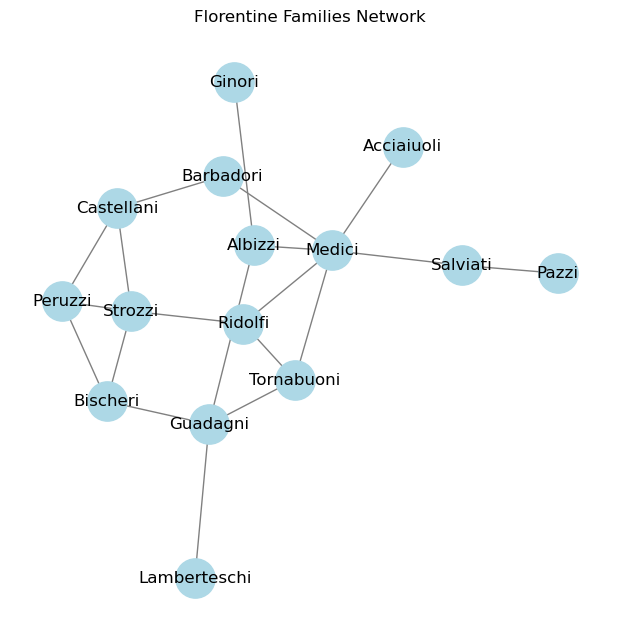

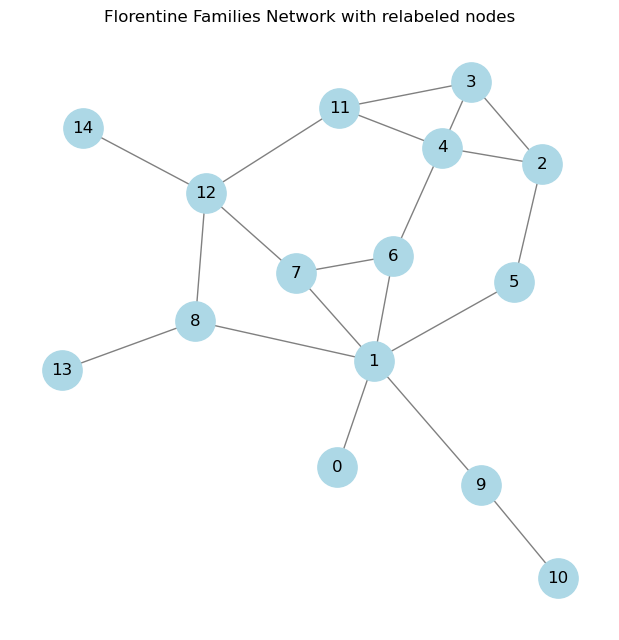

Map from original nodes to new nodes:
{'Acciaiuoli': 0, 'Medici': 1, 'Castellani': 2, 'Peruzzi': 3, 'Strozzi': 4, 'Barbadori': 5, 'Ridolfi': 6, 'Tornabuoni': 7, 'Albizzi': 8, 'Salviati': 9, 'Pazzi': 10, 'Bischeri': 11, 'Guadagni': 12, 'Ginori': 13, 'Lamberteschi': 14}


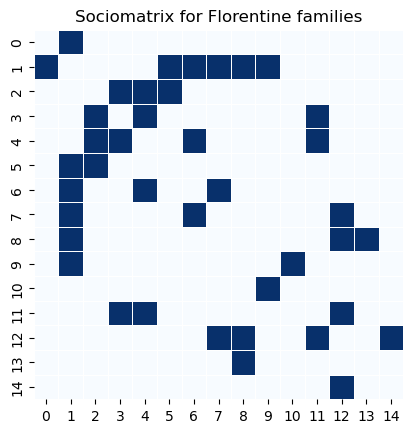

In [3]:
G = nx.florentine_families_graph()

plt.figure(figsize=(6,6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800)
plt.title("Florentine Families Network")
plt.show()

G = nx.florentine_families_graph()
node_mapping = {node: i for i, node in enumerate(G.nodes())}
G = nx.relabel_nodes(G, node_mapping)
n = len(G.nodes)
plt.figure(figsize=(6,6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800)
plt.title("Florentine Families Network with relabeled nodes")
plt.show()
print("Map from original nodes to new nodes:")
print(node_mapping)

Y = nx.to_numpy_array(G, dtype=float)

sns.heatmap(Y, annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("Sociomatrix for Florentine families")
plt.show() 

Metropolis-Hastings for Euclidean latent space models on networks
Number of chains: 2
MH samples of size 5000 with burn-in 5000 and thinning 5
Number of draws per chain: 30000
Initial sigma_q_Z: 1.0000
Initial sigma_q_alpha: 1.0000
Log-likelihood: Bernoulli
------------------------------------------------------------
Searching for MLE using gradient ascent
Best log-likelihood after 20 starts: -29.1055
------------------------------------------------------------
Log-prior:
sigma_prior_Z:  5.0
sigma_prior_alpha:  5.0
********************************
Chain 0
********************************


Sampling progress:  17%|█▋        | 5059/30000 [00:09<00:44, 556.66 draws/s]

--------------------------------
Tuning complete
--------------------------------
Final sigma_q_Z: 0.3721
Final sigma_q_alpha: 0.9850


Sampling progress: 100%|██████████| 30000/30000 [01:00<00:00, 492.30 draws/s]


********************************
Chain 1
********************************


Sampling progress:  17%|█▋        | 5074/30000 [00:09<00:43, 579.59 draws/s]

--------------------------------
Tuning complete
--------------------------------
Final sigma_q_Z: 0.3404
Final sigma_q_alpha: 0.9183


Sampling progress: 100%|██████████| 30000/30000 [00:57<00:00, 519.32 draws/s]


********************************
Trace convergence
********************************
Minimum R-hat: 1.0029
Maximum R-hat: 1.1755
Minimum ESS/n: 0.0052
Maximum ESS/n: 0.0134
********************************
Point information
********************************
----------------------------------------------------------------
Point        Log-likelihood        Log-prior    Log-posterior
----------------------------------------------------------------
Initial            -52.9212         -54.6135        -107.5347
ML                 -29.1055         -63.4467         -92.5522
CM                 -29.0790         -64.8018         -93.8808
MAP                -21.8931         -63.1650         -85.0581
----------------------------------------------------------------
********************************
Model information criteria
********************************
WAIC: 137.5772
DIC: 133.2572
BIC: 240.5434

Final acceptance rate Z: 0.4833
Final acceptance rate alpha: 0.4126
********************************
E

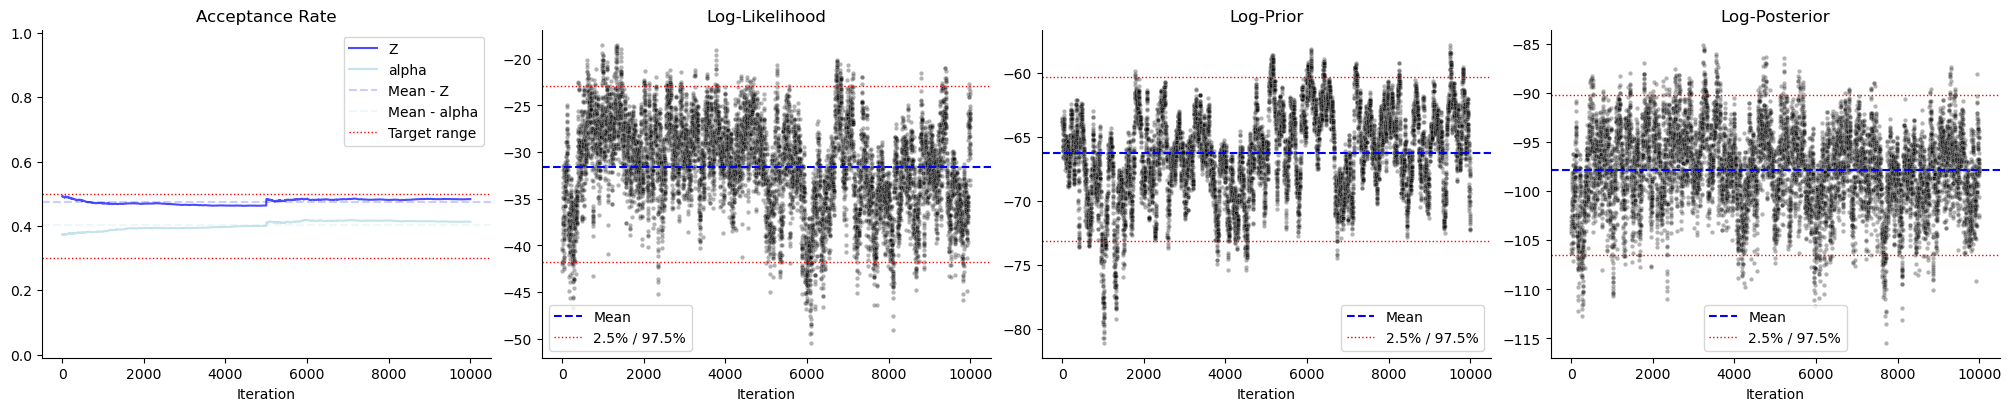

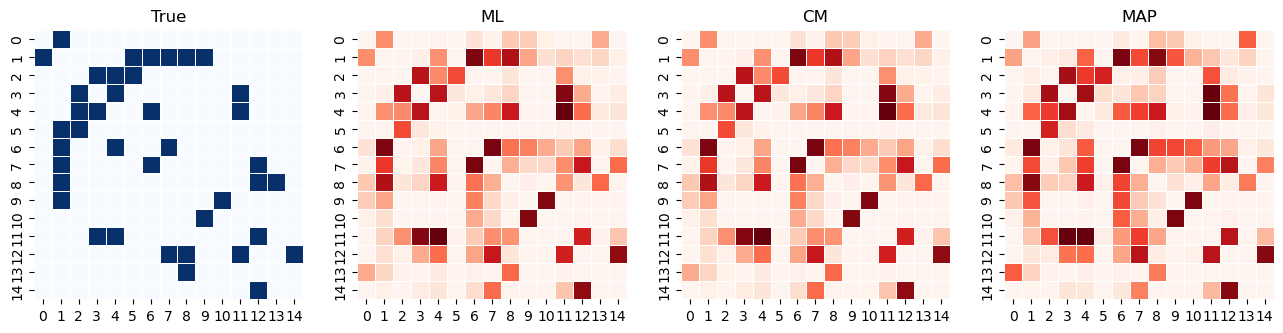

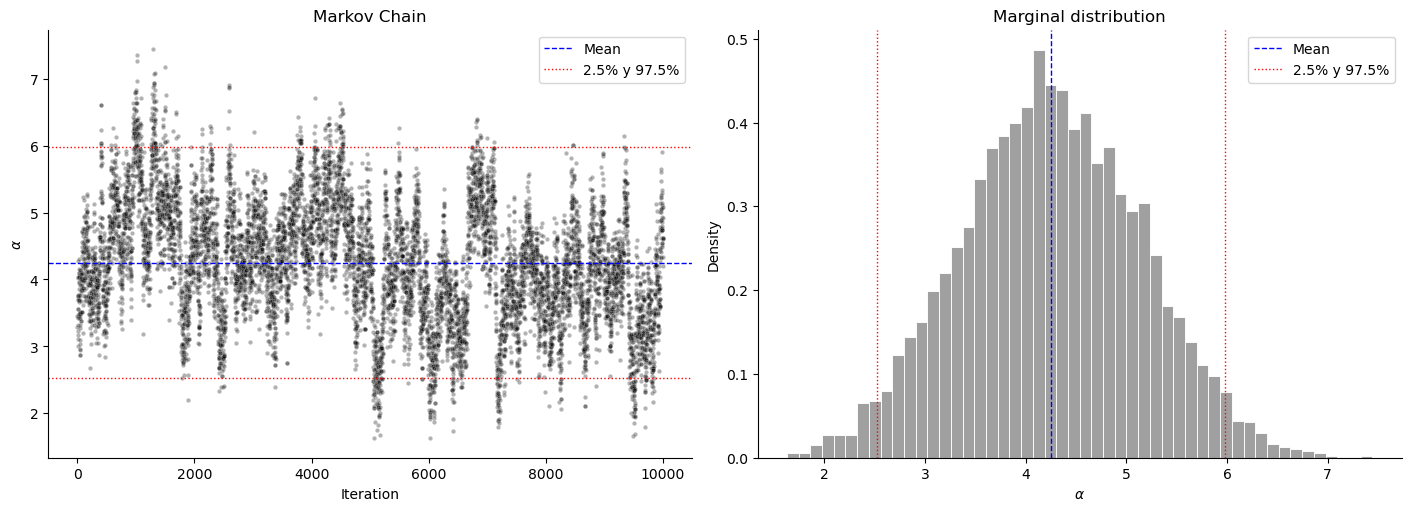

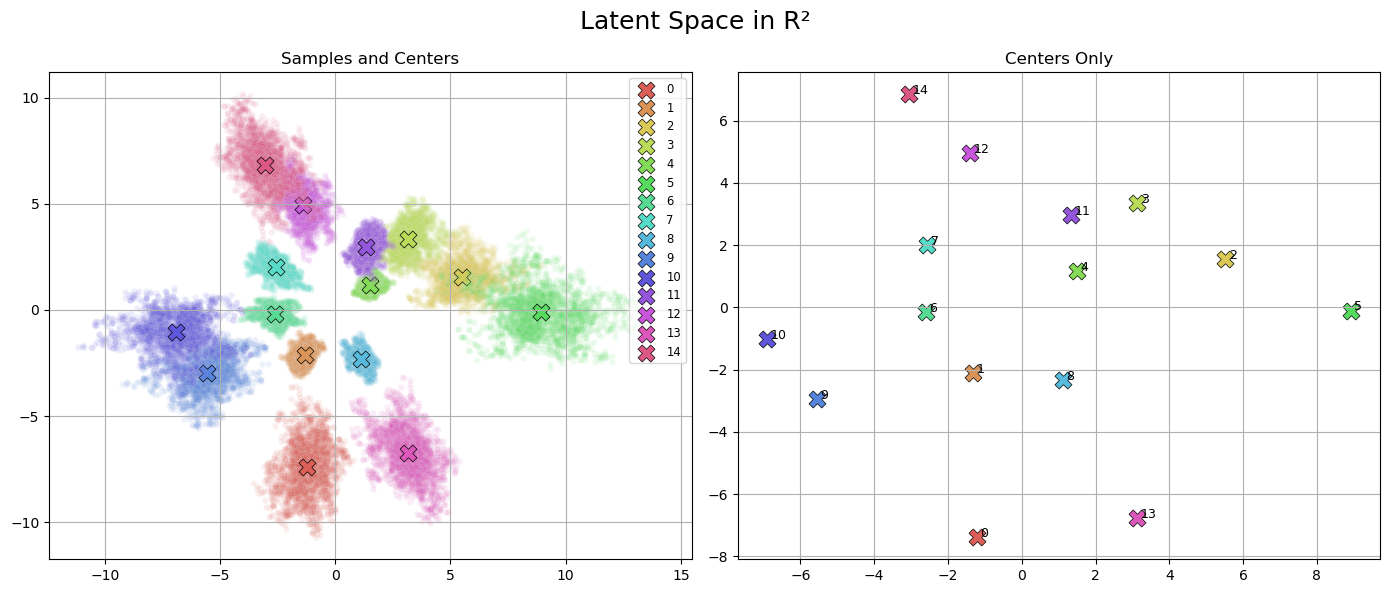

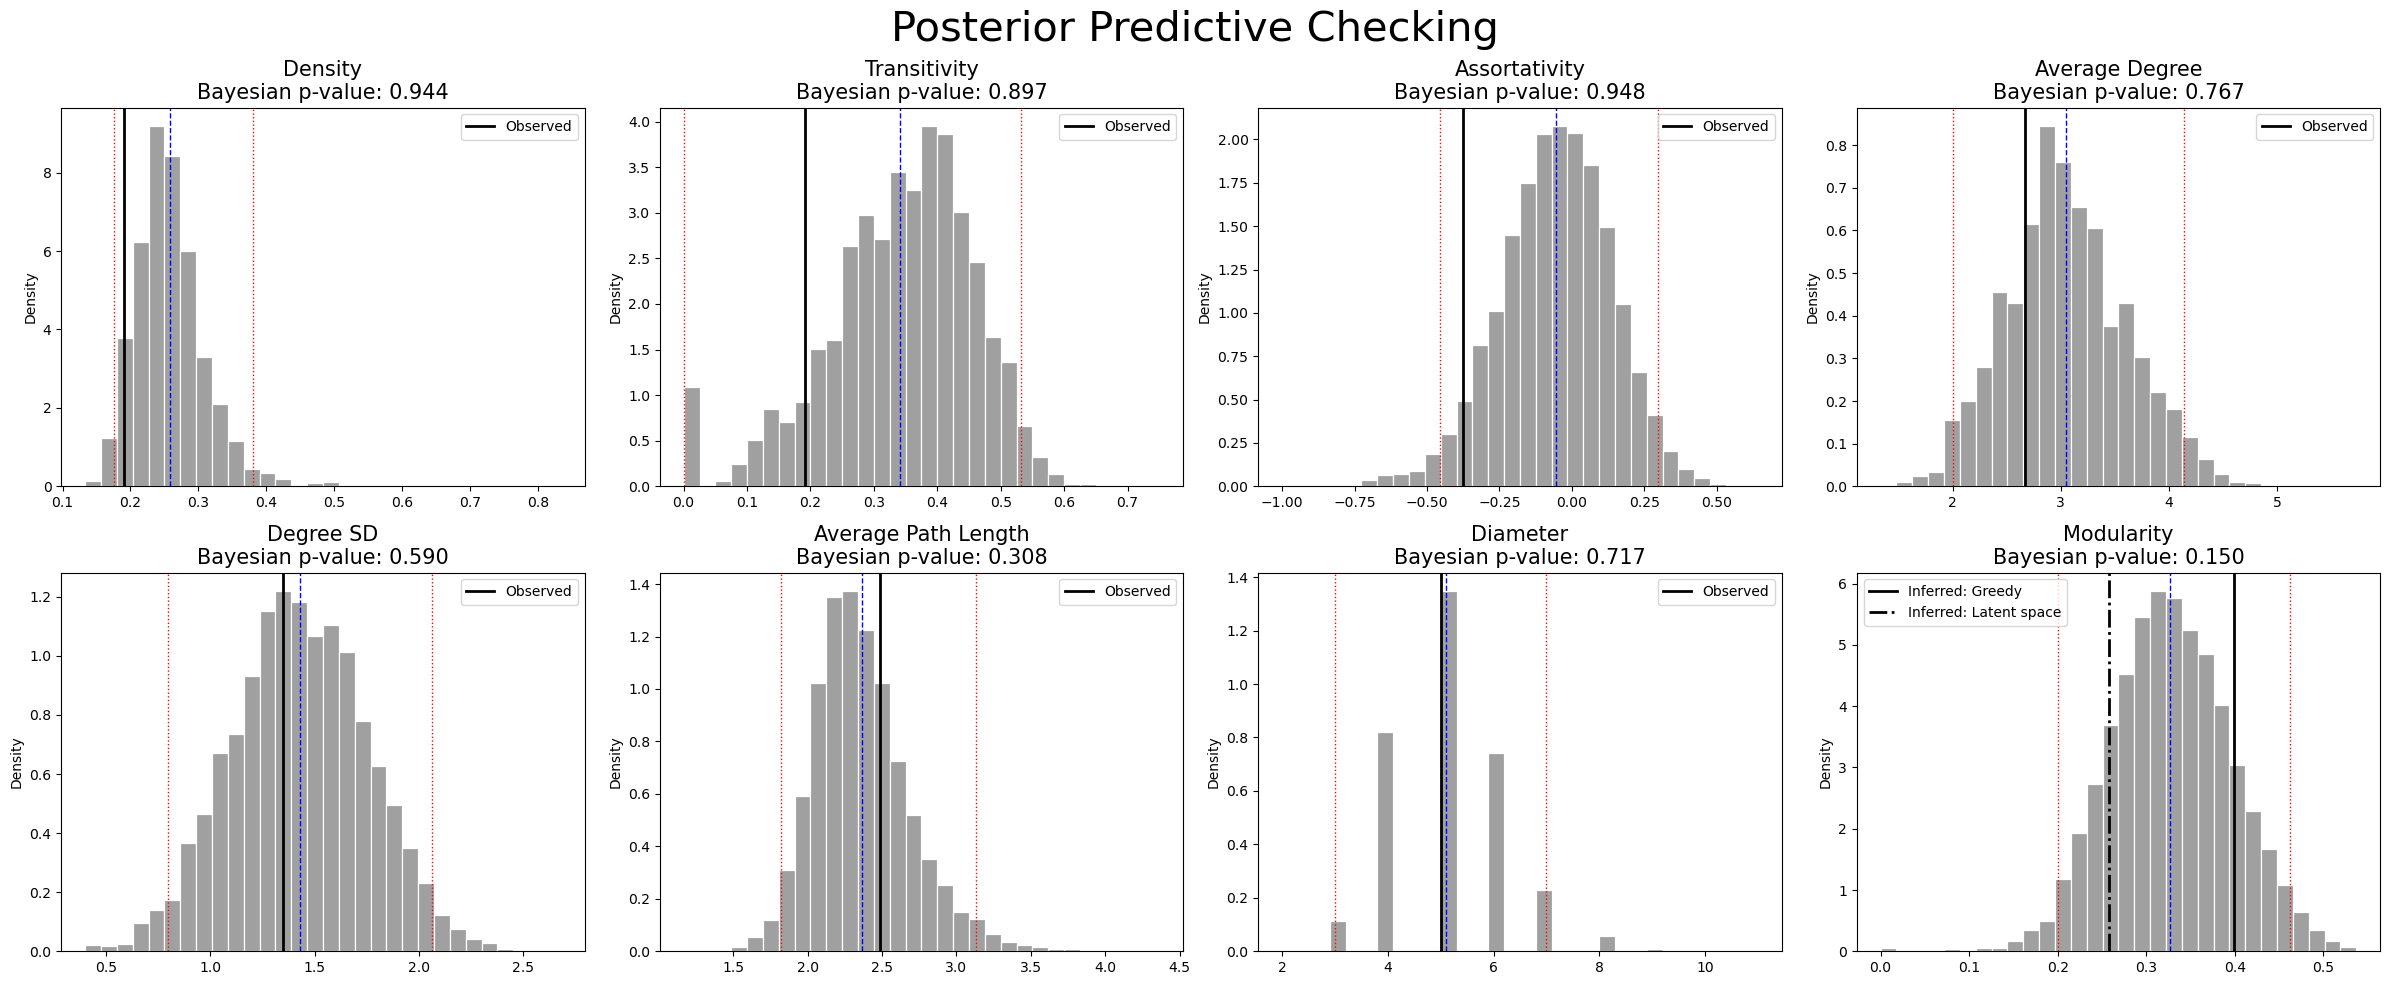

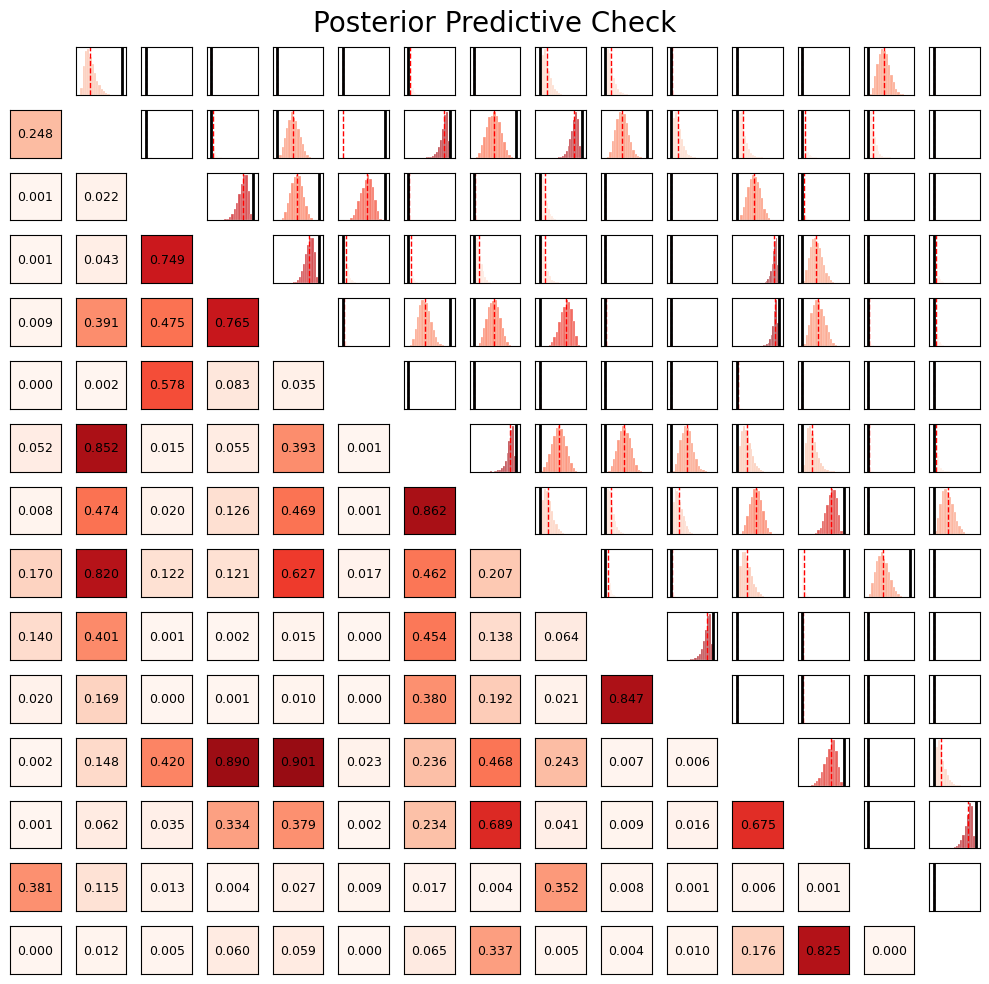

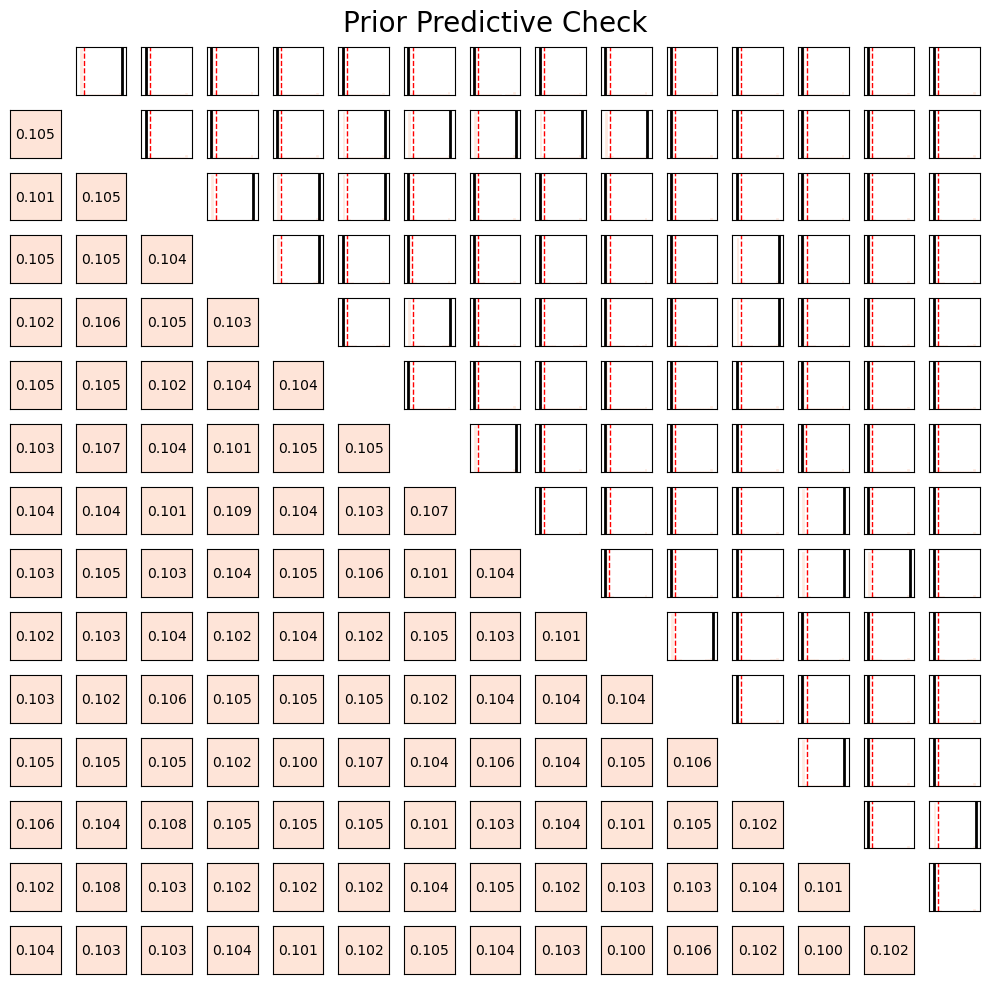

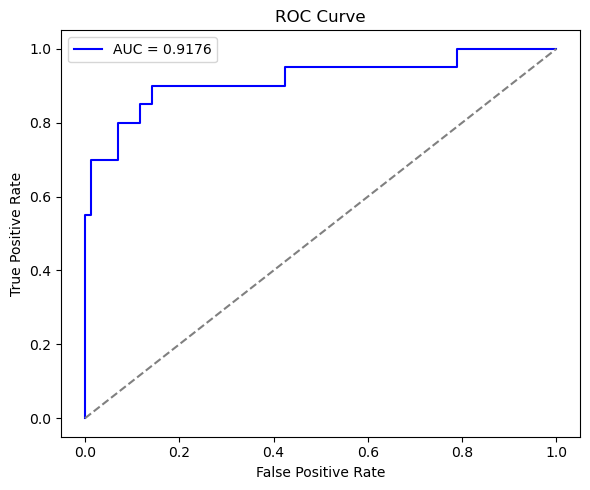

Model: Euclidean
Confussion matrix:  {'tp': 12, 'tn': 84, 'fp': 1, 'fn': 8}
AUC: 0.9176
Accuracy: 0.9143
Precision: 0.9231
Recall: 0.6000
F1-score: 0.7273
Specificity: 0.9882


In [8]:
# Configuration
Theta_R2 = {
    'Z0': np.random.normal(0, 1, size=(n, 2)),
    'alpha0': np.float64(0.0),
    'sigma_prior_Z': 5.0,
    'sigma_prior_alpha': 5.0,
    'n_chains': 2,
    'n_samples': 5000,      
    'burn_in': 5000,       
    'thin': 5,              
    'sigma_q_Z': 1.0,       
    'sigma_q_alpha': 1.0    
}

# Estimation
resultsR2 = Estimation_LSMN(Y, Theta_R2, Model="Euclidean")

# Diagnostic analysis: Acceptance rate, Log probabilities traces, Adjacency matrices of point estimations, Traces of fixed parameters
plot_mcmc_diagnostics_panel(resultsR2)

#Visualizing latent space
plot_latent_space(resultsR2)

# Posterior predictive checking
posterior_predictive_check(resultsR2)

# Prior predictive checking
prior_predictive_check(resultsR2)

# Prediction evaluation
metricsR2 = prediction_evaluation(resultsR2)

Metropolis-Hastings for Spherical latent space models on networks
Number of chains: 2
MH samples of size 5000 with burn-in 5000 and thinning 5
Number of draws per chain: 30000
Initial sigma_q_Z: 50.0000
Initial sigma_q_alpha: 0.5000
Initial sigma_q_beta: 0.5000
Log-likelihood: Bernoulli
------------------------------------------------------------
Searching for MLE using gradient ascent
Best log-likelihood after 20 starts: -40.4390
------------------------------------------------------------
Log-prior:
sigma_prior_alpha:  1.0
sigma_prior_beta:  1.0
********************************
Chain 0
********************************


Sampling progress:  17%|█▋        | 5060/30000 [00:19<01:29, 278.67 draws/s]

--------------------------------
Tuning complete
--------------------------------
Final sigma_q_Z: 5.4091
Final sigma_q_alpha: 0.6880
Final sigma_q_beta: 1.2209


Sampling progress: 100%|██████████| 30000/30000 [02:06<00:00, 236.48 draws/s]


********************************
Chain 1
********************************


Sampling progress:  17%|█▋        | 5028/30000 [00:24<01:52, 221.65 draws/s]

--------------------------------
Tuning complete
--------------------------------
Final sigma_q_Z: 12.1566
Final sigma_q_alpha: 0.6225
Final sigma_q_beta: 1.0305


Sampling progress: 100%|██████████| 30000/30000 [02:25<00:00, 205.90 draws/s]


********************************
Trace convergence
********************************
Minimum R-hat: 0.9999
Maximum R-hat: 1.0015
Minimum ESS/n: 0.0120
Maximum ESS/n: 0.0933
********************************
Point information
********************************
----------------------------------------------------------------
Point        Log-likelihood        Log-prior    Log-posterior
----------------------------------------------------------------
Initial           -175.9773         -29.2622        -205.2395
ML                 -40.4390         -41.3643         -81.8034
CM                 -36.4209         -38.3182         -74.7391
MAP                -35.1793         -37.0647         -72.2440
----------------------------------------------------------------
********************************
Model information criteria
********************************
WAIC: 242.2190
DIC: 200.1532
BIC: 278.2194

Final acceptance rate Z: 0.2353
Final acceptance rate alpha: 0.4602
Final acceptance rate beta: 0.4003

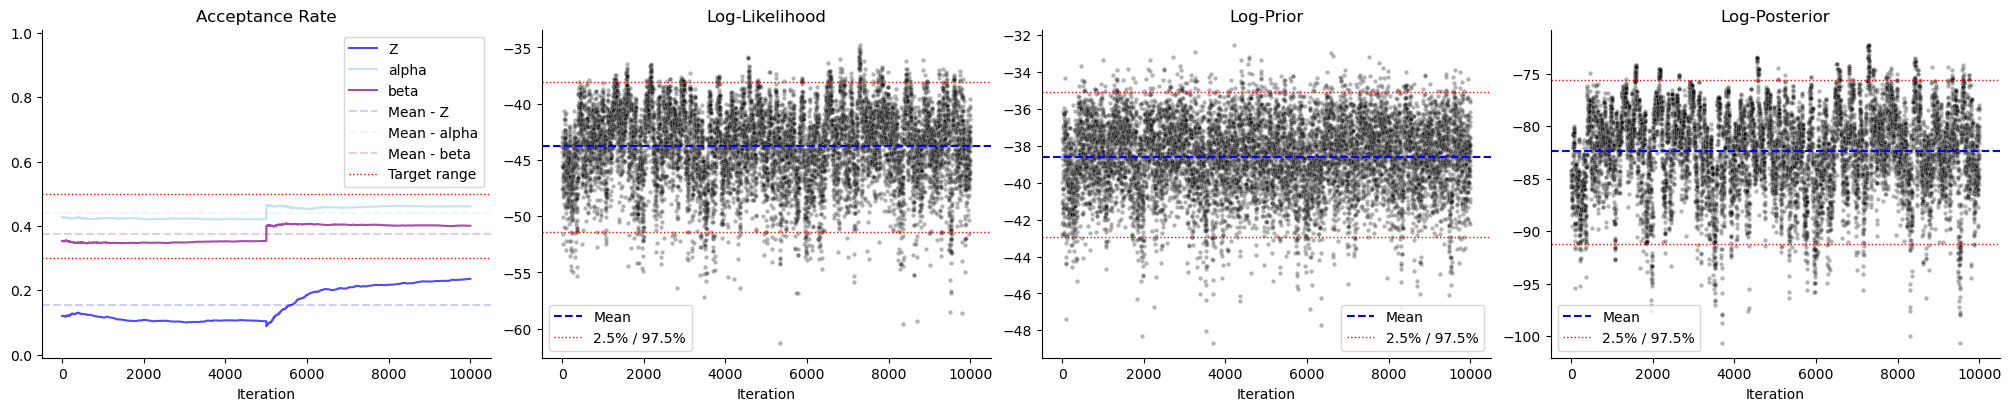

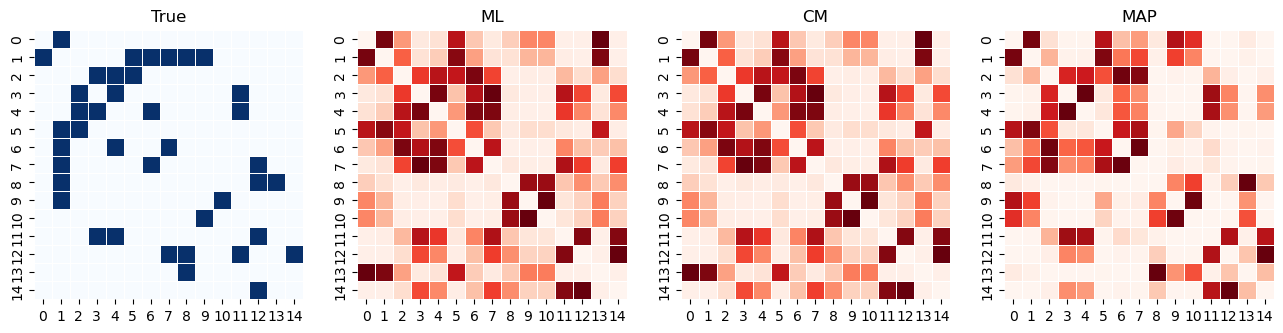

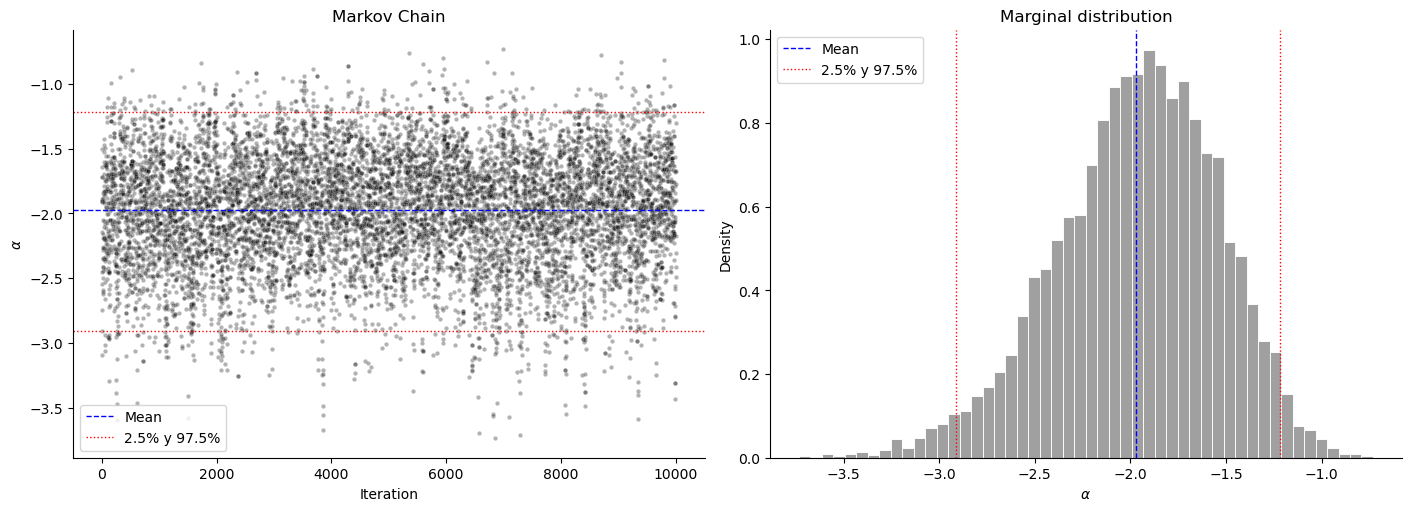

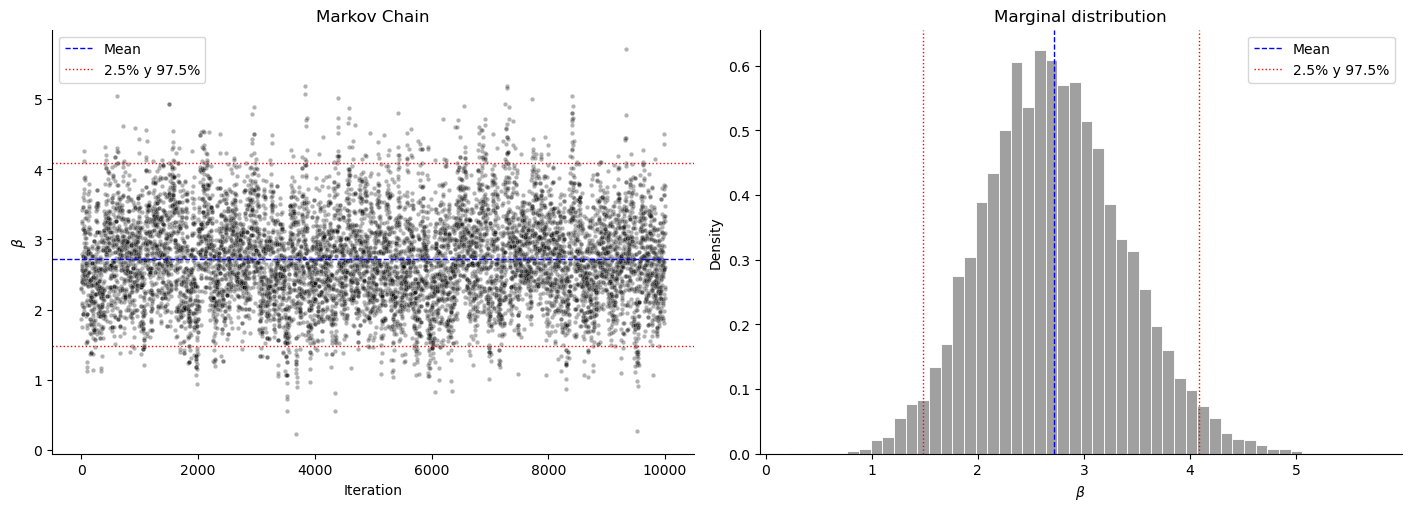

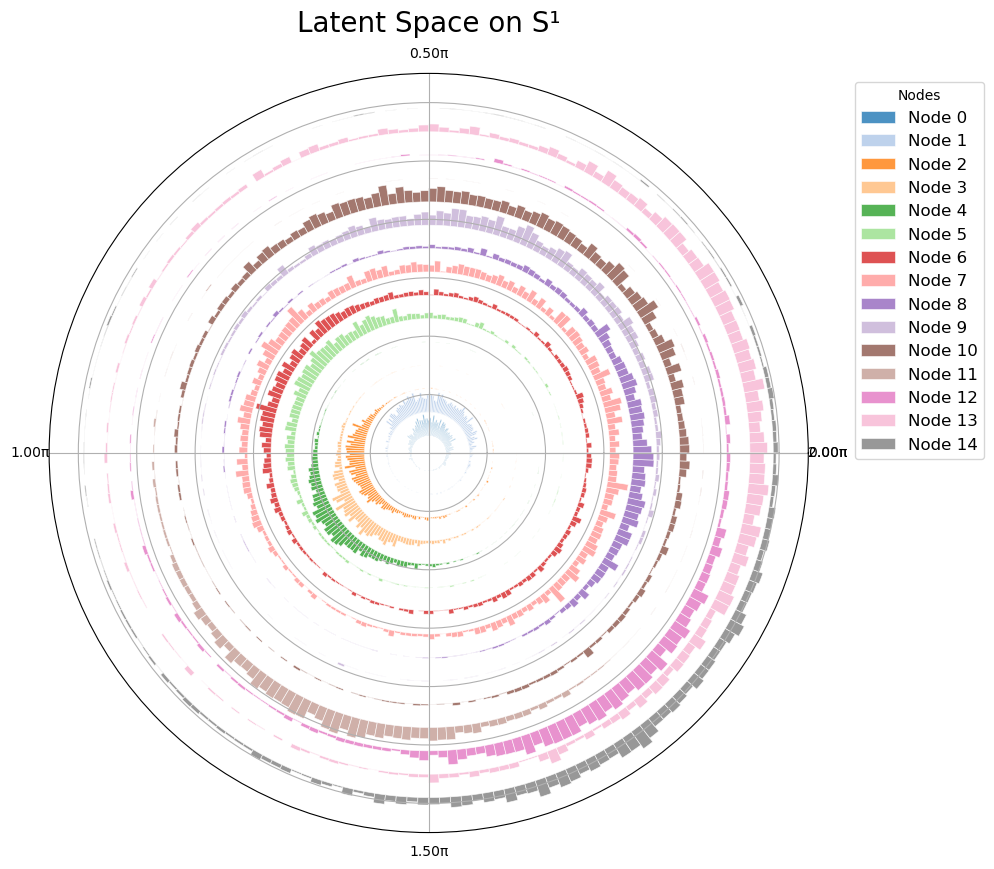

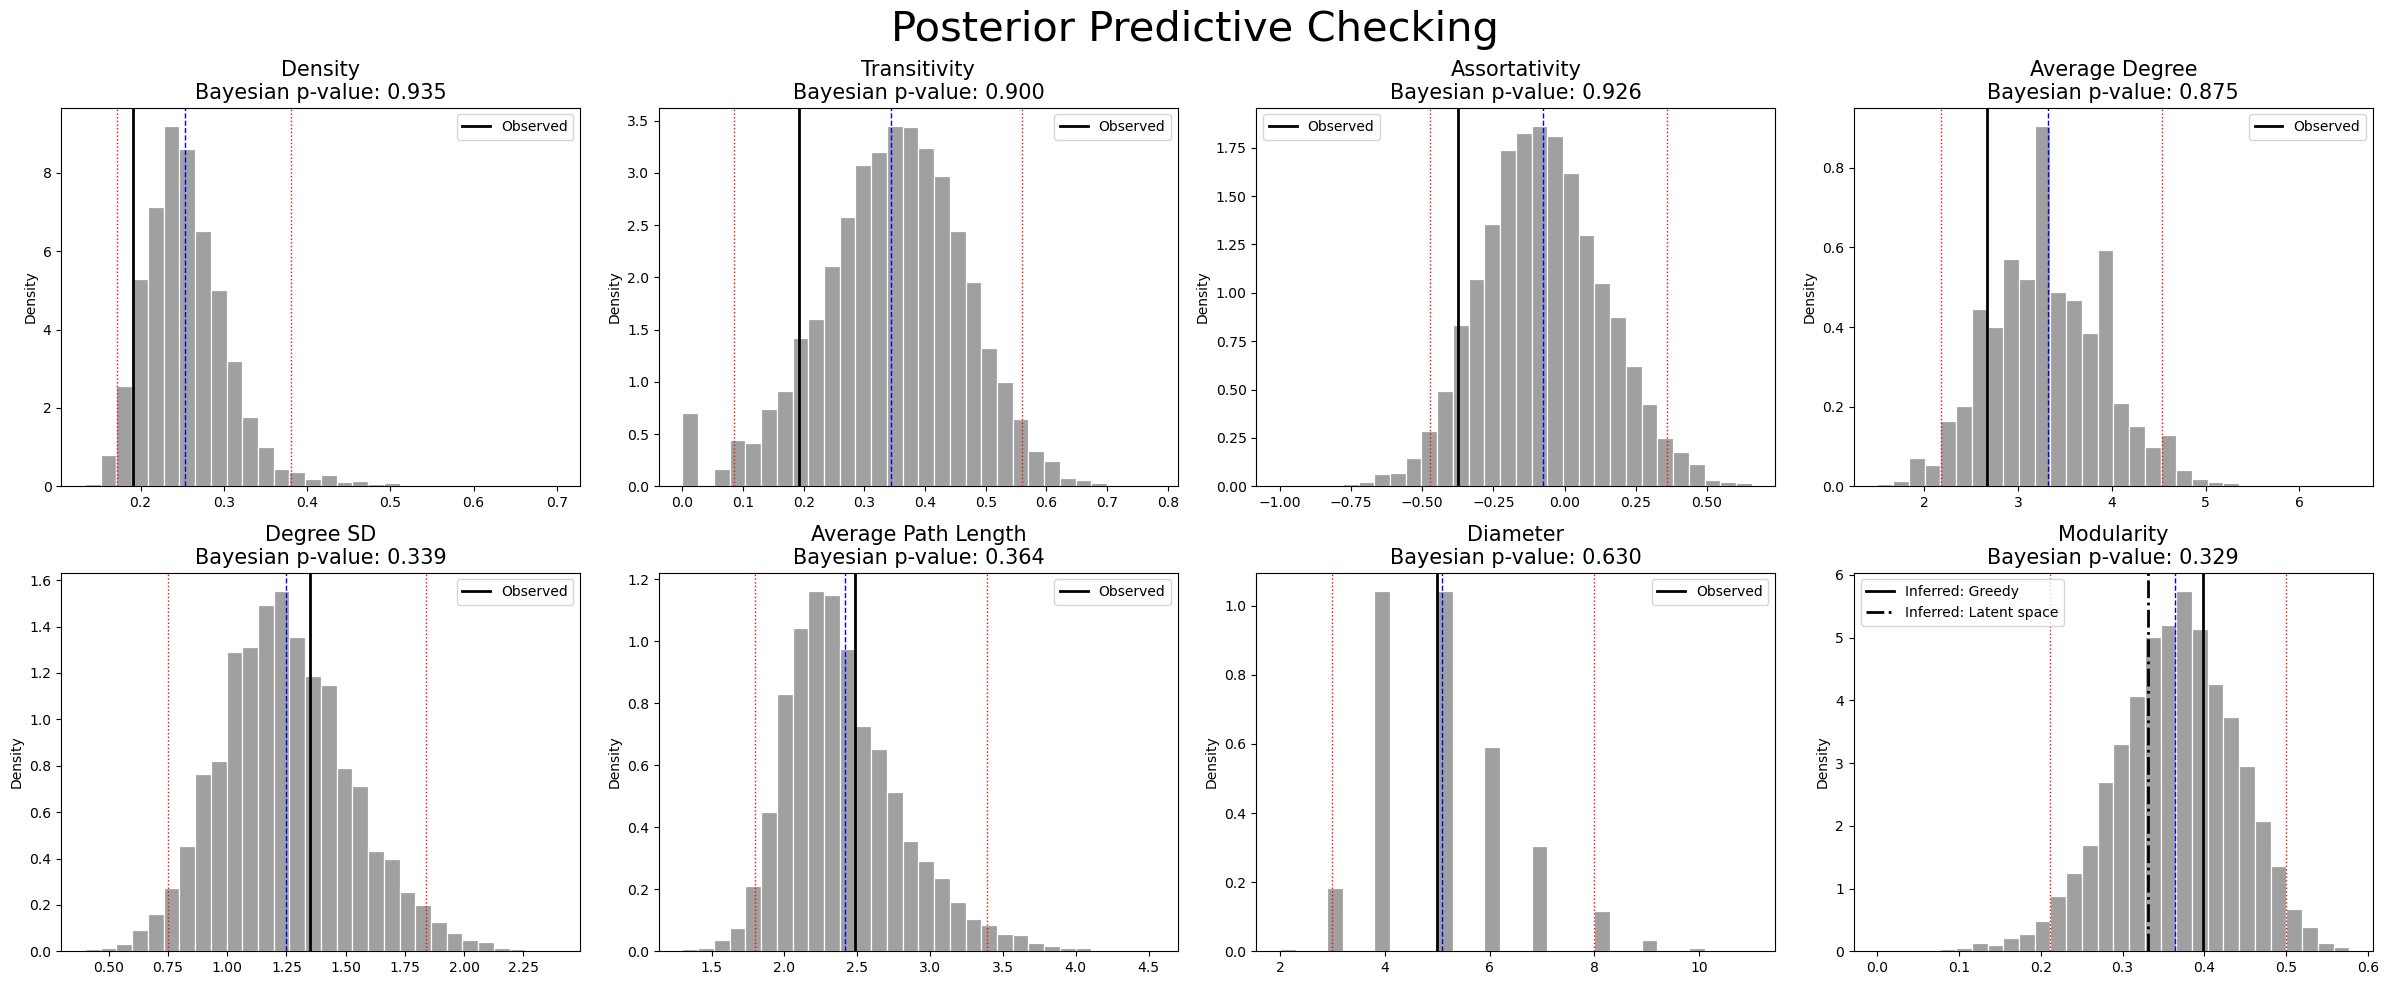

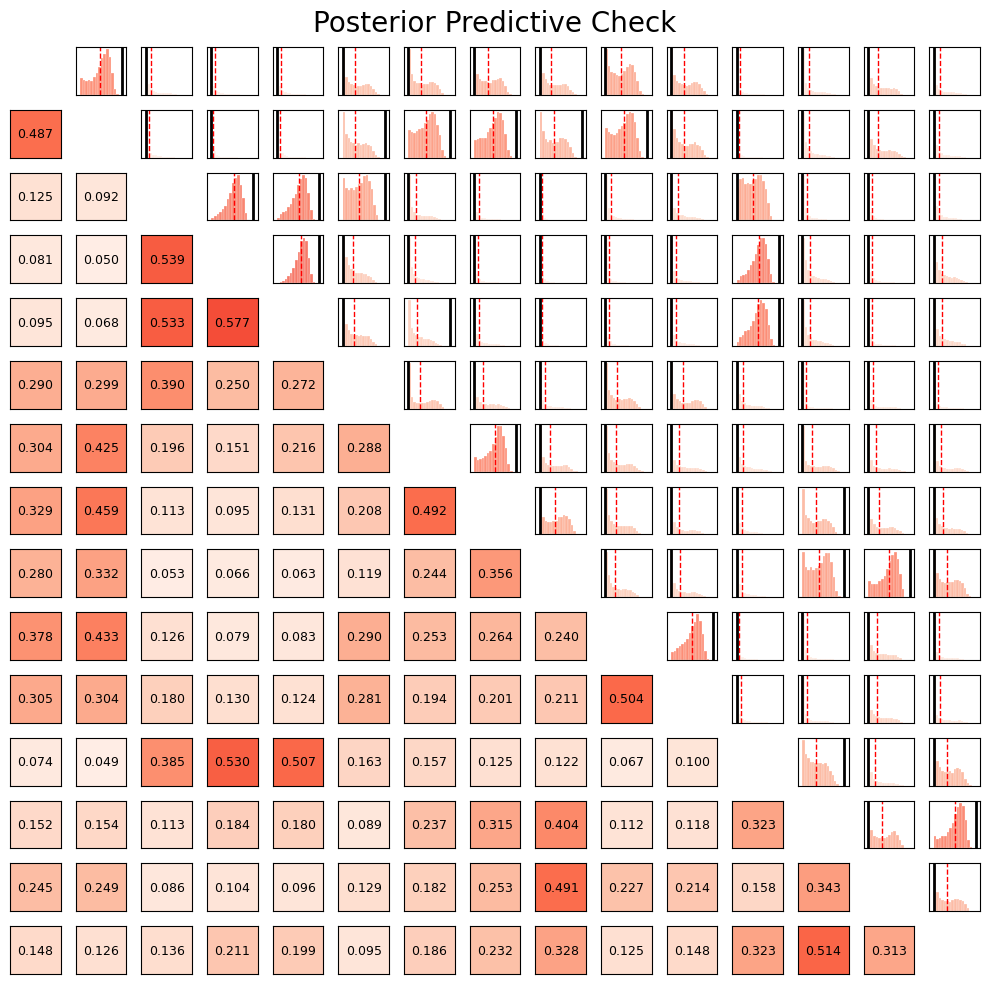

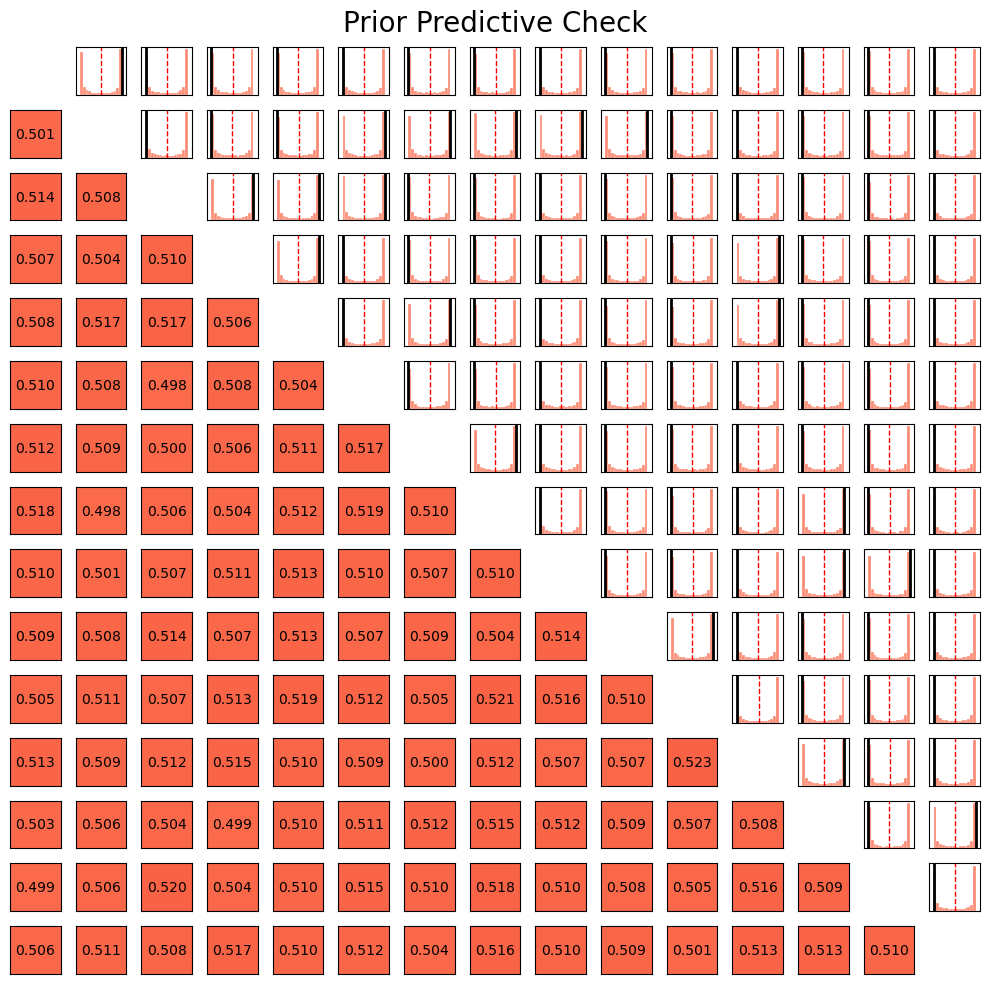

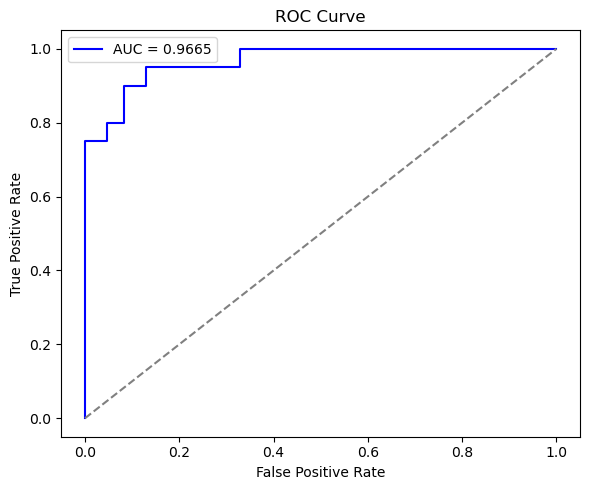

Model: Spherical
Confussion matrix:  {'tp': 7, 'tn': 85, 'fp': 0, 'fn': 13}
AUC: 0.9665
Accuracy: 0.8762
Precision: 1.0000
Recall: 0.3500
F1-score: 0.5185
Specificity: 1.0000


In [10]:
# Configuration
Theta_S1 = {
    'Z0': random_VMF(np.array([0,1]), 0, n),
    'alpha0': np.float64(0.0),
    'beta0': np.float64(5.0),
    'rho': -0.5,
    'mu_alpha_beta': np.array([0.0, 5.0]),
    'sigma_prior_alpha': 1.0,
    'sigma_prior_beta': 1.0,
    'n_chains': 2,
    'n_samples': 5000,      
    'burn_in': 5000,       
    'thin': 5,                
    'sigma_q_Z': 50.0,       
    'sigma_q_alpha': 0.5,    
    'sigma_q_beta': 0.5      
}

# Estimation
resultsS1 = Estimation_LSMN(Y, Theta_S1, Model="Spherical")

# Diagnostic analysis: Acceptance rate, Log probabilities traces, Adjacency matrices of point estimations, Traces of fixed parameters
plot_mcmc_diagnostics_panel(resultsS1)

#Visualizing latent space
plot_latent_space(resultsS1)

# Posterior predictive checking
posterior_predictive_check(resultsS1)

# Prior predictive checking
prior_predictive_check(resultsS1)

# Prediction evaluation
metricsS1 = prediction_evaluation(resultsS1)

# Save results
#handle_results(resultsS1, filepath='resultsS1.pkl', mode='save')